In [ ]:
!pip install koreanize-matplotlib
import koreanize_matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 16.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import linregress

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = "/content/drive/MyDrive/LikeLion/DataTone/exchange_2000_2024.csv"

df = pd.read_csv(file_path)

In [ ]:
exchange_df = df.copy()

# **[주가지수]**

## **가설1 : 한국 주가지수가 상승하면 원화 강세가 기대되어 원/달러 환율이 낮아질 것이다.**

## **상관관계 유의성 검정 (피어슨 상관계수)**

1. 귀무가설(H₀)
- 두 변수(한국 주가지수, 원/달러환율) 사이에 선형 상관관계가 없다 (즉, 모상관계수 ρ=0)

2. 대립가설(H₁)
- 두 변수 사이에 선형 상관관계가 있다 (ρ ≠ 0)









In [ ]:
from scipy.stats import pearsonr

corr_coef, p_value = pearsonr(exchange_df['한국 주가지수'], exchange_df['원/달러환율'])
print(f'p-value: {p_value:.4f}')

p-value: 0.4190


## **원/달러환율 ~ 한국 주가지수 산점도 및 상관관계**

기울기 (Slope): 0.1562
절편 (Intercept): 1138.7590
결정계수 (R²): 0.0022
상관계수 (R): 0.0468


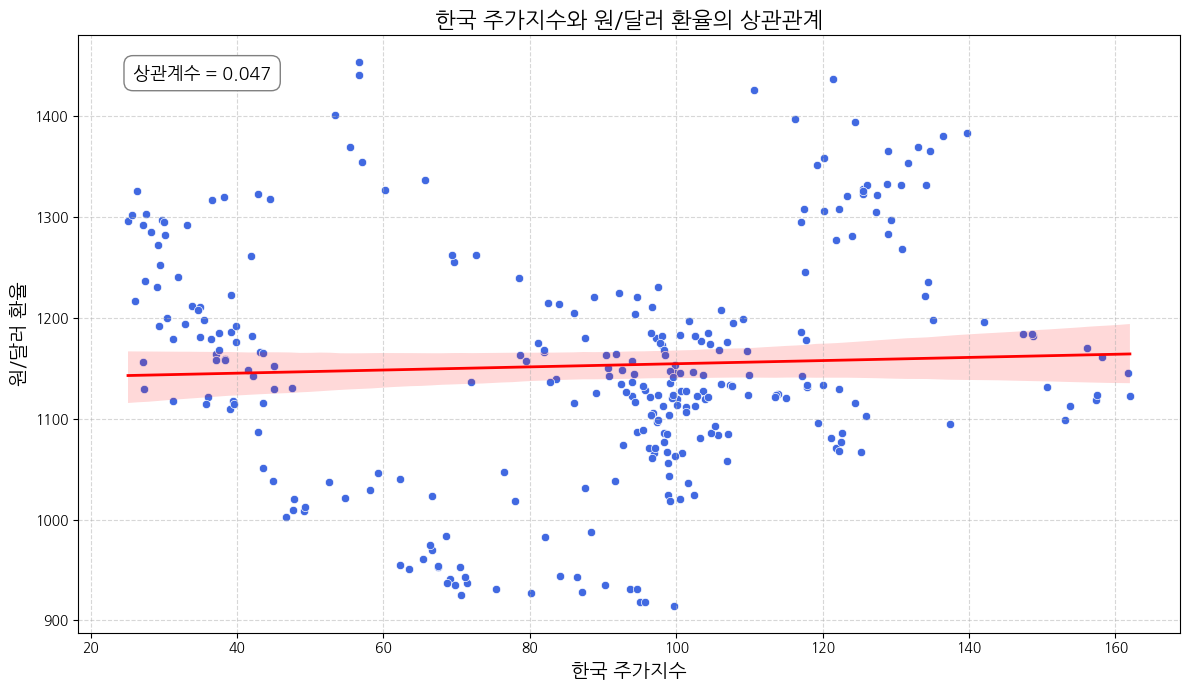

In [ ]:
from scipy.stats import linregress

# 회귀분석 수행
slope, intercept, r_value, p_value, std_err = linregress(exchange_df['한국 주가지수'], exchange_df['원/달러환율'])

# 콘솔에 기울기, 절편, 결정계수(R²), 상관계수(R) 출력
print(f'기울기 (Slope): {slope:.4f}')
print(f'절편 (Intercept): {intercept:.4f}')
print(f'결정계수 (R²): {r_value**2:.4f}')
print(f'상관계수 (R): {r_value:.4f}')

# 산점도
plt.figure(figsize=(12, 7))
sns.scatterplot(x='한국 주가지수', y='원/달러환율', data=exchange_df, color='royalblue')

# 회귀선 추가
sns.regplot(x='한국 주가지수', y='원/달러환율', data=exchange_df,
            scatter=False, color='red', line_kws={'linewidth': 2})

# 화이트 박스에 상관계수(R)만 표시
corr_text = f'상관계수 = {r_value:.3f}'

# 화이트 박스 표시
plt.text(0.05, 0.95, corr_text,
         fontsize=13, transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='gray'))

# 그래프 설정
plt.title('한국 주가지수와 원/달러 환율의 상관관계', fontsize=16)
plt.xlabel('한국 주가지수', fontsize=14)
plt.ylabel('원/달러 환율', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### **해석!**
**1. p-value = 0.4190**
- 귀무가설을 기각할 수 없음
- 즉, 두 변수간에 통계적으로 유의미한 선형 관계가 없음

**2. 상관계수 (R) = 0.0468**
- 거의 0에 가까운 값으로, 두 시계열 간 선형관계가 전혀 없다고 봐야함



## **주요 사건을 중심으로 추론통계 진행**

### **월별(event 단위) ANOVA**
**1. 가설**
- 귀무가설: 모든 이벤트 구간의 평균 환율이 같다
- 대립가설: 적어도 한 구간의 평균이 다르다

**2. 해석**
- F-statistic = 19.750
  - 주요 사건별 평균 차이가 집단 내 변동에 비해 약 19.75배 크다.
- p-value ≈ 0.0000
  - 귀무가설 기각
  - **월별 데이터를 기준으로 “적어도 한 사건 구간의 평균 환율”이 나머지 구간과 통계적으로 유의미하게 다름**

In [ ]:
stock_df = exchange_df.copy()
# 문자열 'YYYY-MM' 형식을 datetime으로 변환
stock_df['TIME'] = pd.to_datetime(stock_df['TIME'], format='%Y-%m', errors='coerce')

# 이벤트 라벨링
def classify_event(date):
    if pd.Timestamp('2008-09') <= date <= pd.Timestamp('2009-06'):
        return '글로벌 금융위기'
    elif pd.Timestamp('2018-03') <= date <= pd.Timestamp('2020-01'):
        return '미중 무역전쟁'
    elif pd.Timestamp('2020-03') <= date <= pd.Timestamp('2021-06'):
        return '코로나 팬데믹'
    elif pd.Timestamp('2022-03') <= date <= pd.Timestamp('2023-07'):
        return '자이언트 스텝'
    elif pd.Timestamp('2022-02') <= date <= pd.Timestamp('2023-12'):
        return '러-우 전쟁'
    else:
        return '평시'

stock_df['주요 사건'] = stock_df['TIME'].map(classify_event)

In [ ]:
import pandas as pd
from scipy.stats import f_oneway

# 주요 사건 라벨링 적용
stock_df = exchange_df.copy()
stock_df['TIME'] = pd.to_datetime(stock_df['TIME'], format='%b-%y', errors='coerce')
stock_df['event'] = stock_df['TIME'].apply(classify_event)

# 그룹별 원/달러환율 시리즈 추출
groups = [ grp['원/달러환율'].values
           for _, grp in stock_df.groupby('event') ]

# One‑way ANOVA
f_stat, p_val = f_oneway(*groups)
print(f"F-statistic = {f_stat:.3f}, p-value = {p_val:.4f}")


F-statistic = 19.750, p-value = 0.0000


### **분기별 ANOVA**
- 분기별 평균을 내서 비교하기

**1. F-statistic = 4.042**
- 집단 간 평균 차이가 집단 내 변동의 약 4배 정도 크다.

**2. p-value = 0.0023**
- p < 0.01 수준으로 귀무가설을 기각
- **분기별로 묶어도 “적어도 한 구간의 평균 분기 환율”이 다른 구간과 유의미한 차이를 보임**

In [ ]:
# 1) 분기별 평균 계산
q_df = (stock_df
        .set_index('TIME')
        .resample('QE')['원/달러환율']
        .mean()
        .reset_index())

# 2) 이벤트 라벨 다시 적용
q_df['event'] = q_df['TIME'].apply(classify_event)

# 3) 분기별 그룹 ANOVA
q_groups = [ grp['원/달러환율'].values
             for _, grp in q_df.groupby('event') ]

f_q, p_q = f_oneway(*q_groups)
print(f"Quarterly F = {f_q:.3f}, p = {p_q:.4f}")


Quarterly F = 4.042, p = 0.0023


### **독립표본 t-검정 (시점 비교)**

**1. 가설**
- 귀무가설 : 두 집단 평균이 같다.

**2. pre_event, post_event**
- pre_event는 주요 사건 연도 이전의 환율 샘플
- post_event는 주요 사건 연도 이후의 환율 샘플

**3. 해석**
- t-statistic = -9.505
  - 음수라는 것은 첫 번째 집단(pre_event)의 평균이 두 번째 집단(post_event)의 평균보다 유의하게 낮음
- p-value ≈ 0.0000
  - “팬데믹 전후 평균 환율이 같다”는 주장은 통계적으로 받아들일 수 없음

In [ ]:
import matplotlib.dates as mdates
stock_df = exchange_df.copy()
stock_df['TIME'] = pd.to_datetime(stock_df['TIME'], format='%b-%y', errors='coerce')

# 연도, 분기 컬럼 생성
stock_df['연도'] = stock_df['TIME'].dt.year
stock_df['분기'] = stock_df['TIME'].dt.quarter

# 분기별 상관계수 계산
records = []

for (y, q), group in stock_df.groupby(['연도', '분기']):
    if len(group) >= 2:
        r = group['한국 주가지수'].corr(group['원/달러환율'])
        records.append({'연도': y, '분기': f'Q{q}', '상관계수': r})

In [ ]:
# 코로나 (2020년) 이전과 이후 환율 비교
pre_event = stock_df[stock_df['연도'] < 2020]['원/달러환율']
post_event = stock_df[stock_df['연도'] >= 2020]['원/달러환율']

from scipy.stats import ttest_ind
t_stat, p_val = ttest_ind(pre_event, post_event, equal_var=False)
print(f't-statistic: {t_stat:.3f}, p-value: {p_val:.4f}')


t-statistic: -9.505, p-value: 0.0000


### **사후 검정 - Tukey HSD**

**1. 개념**
- 일원배치 분산분석(ANOVA)에서 “전체적으로 집단 간 평균 차이가 있다”는 결과를 얻은 뒤,
- 어떤 집단끼리 평균이 유의미하게 다른지를 알아보기 위한 사후 검정

**2. 모든 쌍별 평균 비교**
- ANOVA가 “적어도 한 집단쌍”의 평균이 다르다고만 알려주는 반면,
- Tukey HSD는 집단 A vs B, A vs C, … 모든 가능한 조합을 동시에 비교하여 어느 쌍이 유의한 차이를 보이는지 구체적으로 파악

**3.주요 가정**
- 집단 간/내 독립성
- 각 집단 정규성
- 등분산성(homogeneity of variances)

In [ ]:
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
stock_df['주요 사건'] = stock_df['TIME'].map(classify_event)

mc = pairwise_tukeyhsd(stock_df['원/달러환율'],
                       stock_df['주요 사건'],
                       alpha=0.05)
display(mc.summary())

group1,group2,meandiff,p-adj,lower,upper,reject
글로벌 금융위기,러-우 전쟁,-31.0067,0.9905,-177.7501,115.7368,False
글로벌 금융위기,미중 무역전쟁,-193.7257,0.0,-301.3641,-86.0872,True
글로벌 금융위기,자이언트 스텝,-29.7259,0.9749,-142.9742,83.5225,False
글로벌 금융위기,코로나 팬데믹,-177.11,0.0002,-291.6616,-62.5584,True
글로벌 금융위기,평시,-203.3066,0.0,-295.1177,-111.4954,True
러-우 전쟁,미중 무역전쟁,-162.719,0.0053,-292.9858,-32.4521,True
러-우 전쟁,자이언트 스텝,1.2808,1.0,-133.6585,136.22,False
러-우 전쟁,코로나 팬데믹,-146.1033,0.0272,-282.1382,-10.0685,True
러-우 전쟁,평시,-172.2999,0.0005,-289.8274,-54.7725,True
미중 무역전쟁,자이언트 스텝,163.9998,0.0,73.1098,254.8898,True


### **해석!**

**1. 유의미하게 차이가 있는 비교 (reject = True)**

| 비교                                         | meandiff               | 해석                                                   |
|--------------------------------------------|------------------------|------------------------------------------------------|
| 글로벌 금융위기 vs 미중 무역전쟁             | −193.73 (p < 0.001)    | 금융위기 기간 평균환율이 무역전쟁 기간보다 약 194원 낮음       |
| 글로벌 금융위기 vs 코로나 팬데믹             | −177.11 (p = 0.0002)   | 금융위기 기간 환율이 팬데믹 기간보다 약 177원 낮음            |
| 글로벌 금융위기 vs 평시                     | −203.31 (p < 0.001)    | 금융위기 기간 환율이 평시보다 약 203원 낮음                  |
| 러‑우 전쟁 vs 미중 무역전쟁                  | −162.72 (p = 0.0053)   | 러‑우 전쟁 기간 환율이 무역전쟁 기간보다 약 163원 낮음        |
| 러‑우 전쟁 vs 코로나 팬데믹                  | −146.10 (p = 0.0272)   | 러‑우 전쟁 기간 환율이 팬데믹 기간보다 약 146원 낮음          |
| 러‑우 전쟁 vs 평시                          | −172.30 (p = 0.0005)   | 러‑우 전쟁 기간 환율이 평시보다 약 172원 낮음                |
| 미중 무역전쟁 vs 자이언트 스텝               | 163.99 (p < 0.001)     | 무역전쟁 기간 환율이 자이언트 스텝 기간보다 약 164원 높음     |
| 자이언트 스텝 vs 코로나 팬데믹               | −147.38 (p = 0.0004)   | 자이언트 스텝 기간 환율이 팬데믹 기간보다 약 147원 낮음       |
| 자이언트 스텝 vs 평시                       | −173.58 (p < 0.001)    | 자이언트 스텝 기간 환율이 평시보다 약 174원 낮음              |

**2. 유의미하지 않은 비교 (reject = False)**
- 유의하지 않음(p-adj ≥ 0.05)
  - 글로벌 금융위기 vs 러‑우 전쟁, vs 자이언트 스텝
  - 러‑우 전쟁 vs 자이언트 스텝
  - 코로나 팬데믹 vs 평시

## **월별 변화량 (diff)**

**1. 원본(level) vs 차분(diff)을 적용했을 때 차이**

| 구분       | 레벨(level)                                                           | 차분(diff)                                                              |
|----------|----------------------------------------------------------------------|------------------------------------------------------------------------|
| **검정 대상**   | 사건 구간별 평균 환율(예: 1,200원 vs 1,400원)                             | 사건 구간별 평균 월간 변화량(예: +10원/월 vs +5원/월)                           |
| **해석**      | “이 기간 동안 환율 수준이 서로 달랐다”                                       | “이 기간 동안 환율이 월평균 얼마씩 올랐/내려갔는지 차이가 있다”                      |
| **가정 충족**  | 비정상성(non‑stationarity, 추세) → 잘 안 맞으면 오차 분산분석이 왜곡될 수 있음     | 1차 차분으로 보통 정상성에 가까워짐 → 독립성·정규성 가정에 좀 더 부합               |
| **언제 쓰나?** | 사건별 ‘평균 수준(level)’ 차이를 알고 싶을 때                                | 사건별 ‘변동성(returns)’ 차이를 알고 싶을 때                                      |

<br>

**2. 두 검정의 차이**
- 레벨(level) 검정

  - 연구 질문이 “A 기간의 환율이 B 기간보다 얼마나 높은가/낮은가?”에 초점
  - 예: “코로나 팬데믹 동안 환율 수준이 평시보다 높았는가?”

- 차분(diff) 검정
  - 연구 질문이 “A 기간 동안 환율이 얼마나 많이 움직였는가?”에 초점
  - 예: “글로벌 금융위기 기간 월평균 환율 변동폭이 다른 사건 기간보다 컸는가?”

### **정상성 검정 ADF**

**1. 해석**
- p < 0.05: 정상성 있음 → 그대로 사용 가능
- p ≥ 0.05: 비정상 → 차분 후 사용해야 함

**2. 변수 → 둘 다 diff 적용해야함**
- 주가 지수
- 원/달러 환율

In [ ]:
from statsmodels.tsa.stattools import adfuller

adf_kospi = adfuller(exchange_df['한국 주가지수'].dropna())
adf_usdkrw = adfuller(exchange_df['원/달러환율'].dropna())
print(f'ADF 주가지수 p-value: {adf_kospi[1]:.4f}')
print(f'ADF 환율 p-value: {adf_usdkrw[1]:.4f}')

ADF 주가지수 p-value: 0.3651
ADF 환율 p-value: 0.4209


### **diff 적용 후, 통계 검정**

In [ ]:
import pandas as pd
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# 1) 차분 계산
stock_df['TIME'] = pd.to_datetime(stock_df['TIME'], format='%b-%y', errors='coerce')
stock_df['diff'] = stock_df['원/달러환율'].diff()
# 첫 행이 NaN이 되므로 제거
stock_df = stock_df.dropna(subset=['diff'])

# 2) 이벤트 라벨링
stock_df['주요 사건'] = stock_df['TIME'].apply(classify_event)

# 3) 사건별 diff 그룹
groups_diff = [ grp['diff'].values
                for _, grp in stock_df.groupby('주요 사건') ]

# 4) One‑way ANOVA (diff)
f_diff, p_diff = f_oneway(*groups_diff)
print(f"Diff-level F = {f_diff:.3f}, p = {p_diff:.4f}")

# 5) Tukey HSD (diff)
tukey_diff = pairwise_tukeyhsd(endog=stock_df['diff'],
                               groups=stock_df['주요 사건'],
                               alpha=0.05)
display(tukey_diff.summary())


Diff-level F = 1.532, p = 0.1797


<ipython-input-15-0af8fd80510f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['주요 사건'] = stock_df['TIME'].apply(classify_event)


group1,group2,meandiff,p-adj,lower,upper,reject
글로벌 금융위기,러-우 전쟁,-17.4587,0.8058,-57.1717,22.2543,False
글로벌 금융위기,미중 무역전쟁,-17.7787,0.4994,-46.9088,11.3513,False
글로벌 금융위기,자이언트 스텝,-16.4894,0.6364,-47.1376,14.1589,False
글로벌 금융위기,코로나 팬데믹,-26.0901,0.1547,-57.0911,4.9108,False
글로벌 금융위기,평시,-21.6551,0.1274,-46.5041,3.194,False
러-우 전쟁,미중 무역전쟁,-0.3201,1.0,-35.574,34.9339,False
러-우 전쟁,자이언트 스텝,0.9693,1.0,-35.5491,37.4878,False
러-우 전쟁,코로나 팬데믹,-8.6315,0.9848,-45.4464,28.1835,False
러-우 전쟁,평시,-4.1964,0.999,-36.0045,27.6117,False
미중 무역전쟁,자이언트 스텝,1.2894,1.0,-23.3081,25.8868,False


### **해석!**
- p = 0.1797
  - p > 0.05 이므로 귀무가설(“모든 사건 구간의 평균 월간 변화량이 같다”)을 기각할 수 없음
- 사건별로 월간 환율 변화(차분)의 평균이 통계적으로 유의미하게 다르지 않다고 볼 수 있음


### **Cross-Correlation (교차 상관)**
**1. 정의**
- 두 시계열 데이터가 시간차(lag)만큼 이동했을 때 상관계수

- 시계열 간의 선행·후행 관계, 즉 어느 변수가 다른 변수보다 먼저 움직이는지를 파악 가능

**2. 고려 사항**
- 비정상성(non-stationarity): 두 시계열 모두 **평균·분산이 일정해야** 의미 있는 결과

- 과적합 위험: 너무 많은 지연을 고려하면 의미 없는 노이즈가 포함될 수 있음

**3. Lags(시차) : ±12개월**
- 분기별, 월별, 계절별 패턴이 존재할 수 있으니 파악하기 위해 1년을 기준으로 설정

#### **원본 데이터 (비정상성)**

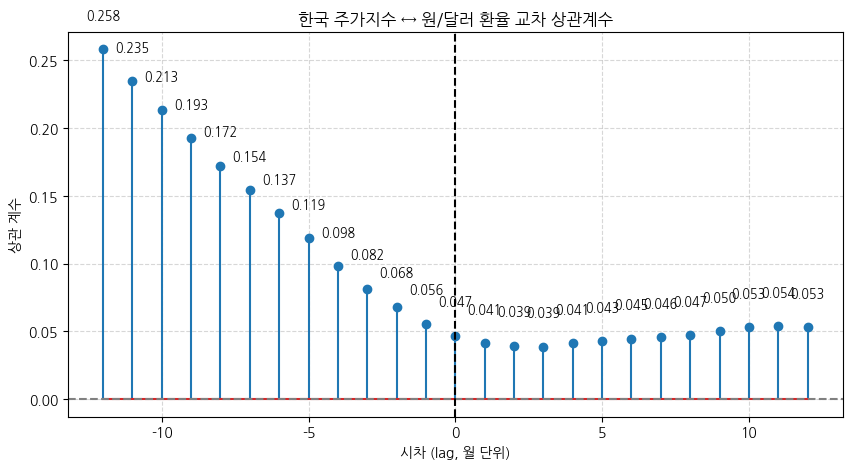

In [ ]:
from statsmodels.tsa.stattools import ccf

lags = range(-12,13)
cc = [exchange_df['원/달러환율'].corr(exchange_df['한국 주가지수'].shift(-lag))
      for lag in lags]

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.stem(lags, cc)
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--')
plt.xlabel('시차 (lag, 월 단위)')
plt.ylabel('상관 계수')
plt.title('한국 주가지수 ↔ 원/달러 환율 교차 상관계수')
plt.grid(True, linestyle='--', alpha=0.5)
# 수치 표시
for x, y in zip(lags, cc):
    plt.text(x, y + 0.02, f"{y:.3f}", ha='center', va='bottom', fontsize=9)
plt.show()


#### **정상성을 적용한 데이터 (월간 변화량)**

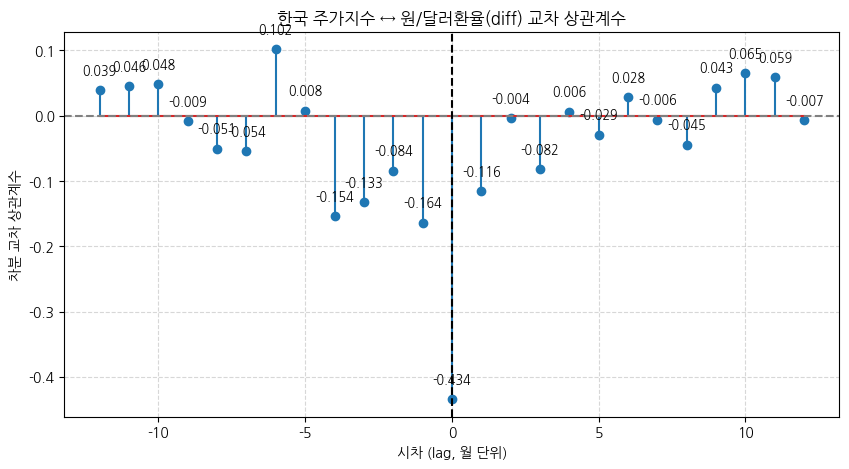

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 차분 계산
df = exchange_df.copy()
df['krw_diff'] = df['원/달러환율'].diff()
df['kospi_diff'] = df['한국 주가지수'].diff()
df = df.dropna(subset=['krw_diff','kospi_diff'])

# lag별 교차상관계수 계산 (diff)
lags = range(-12, 13)
cc_diff = [
    df['krw_diff'].corr(df['kospi_diff'].shift(-lag))
    for lag in lags
]

# 그래프 출력
plt.figure(figsize=(10, 5))
plt.stem(lags, cc_diff)
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--')
plt.xlabel('시차 (lag, 월 단위)')
plt.ylabel('차분 교차 상관계수')
plt.title('한국 주가지수 ↔ 원/달러환율(diff) 교차 상관계수')
plt.grid(True, linestyle='--', alpha=0.5)

# 수치 표시
for x, y in zip(lags, cc_diff):
    plt.text(x, y + 0.02, f"{y:.3f}", ha='center', va='bottom', fontsize=9)

plt.show()

### **해석!**
**1. 기준**
- 그래프 중앙 lag0은 동일한 시점의 외국인 투자 금액과 원/달러 환율의 상관관계를 의미

**2. 왼쪽 구간 (lag<0) : 환율 선행 (환율이 먼저 발생)**
- lag = -6에서 0.102 제일 높은 상관관계를 보임
- 6개월 전 환율 상승 → 한국 주가지수 증가

**3. 오른쪽 구간 (lag>0) : 미국 주가지수 선행 (미국 주가지수가 먼저 발생)**
- lag = +1에서 -0.116 상관관계를 보임
- 1개월 전 한국 주가지수 증가 → 환율 하락

### **Granger 인과검정**
**1. 정의**
- 과거의 한 변수 값이 다른 변수의 미래 값을 예측하는 데 통계적으로 유의미한 정보를 제공하는지”를 검정하는 방법

**2. 귀무·대립가설**
- 귀무가설(H₀): 변수 X의 과거 정보가 Y의 미래 값을 예측하는 데 도움이 되지 않는다.
- 대립가설(H₁): 변수 X의 과거 정보가 Y 예측에 유의미하게 기여한다.

- 과적합 위험: 너무 많은 지연을 고려하면 의미 없는 노이즈가 포함될 수 있음

**3. Lags(시차) : ±12개월**
- 분기별, 월별, 계절별 패턴이 존재할 수 있으니 파악하기 위해 1년을 기준으로 설정

**4. 해석**
- “X를 알면 Y를 예측하는 데 도움이 된다/안 된다”로 이해해야 한다.

In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

# 1) Granger 인과검정 실행
data = exchange_df[['원/달러환율','한국 주가지수']].dropna()
max_lag = 2
results = grangercausalitytests(data, maxlag=max_lag, verbose=False)

# 2) 결과를 리스트에 수집
rows = []
for lag, res in results.items():
    f_stat, p_value, _, _ = res[0]['ssr_ftest']  # ssr based F test
    rows.append({
        'lag': lag,
        'F-statistic': round(f_stat, 4),
        'p-value': round(p_value, 4),
        '유의 여부 (p<0.05)': p_value < 0.05
    })

# 3) DataFrame으로 변환 후 출력
df_gc = pd.DataFrame(rows).set_index('lag')
display(df_gc)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


,F-statistic,p-value,유의 여부 (p<0.05)
lag,,,
1,1.7170,0.1911,False
2,0.8979,0.4086,False


### **해석!**
1. 한국 주가지수의 과거 1~2개월 값을 알아도 환율을 예측할 수 없다"고 결론

-> 한국 주가지수가 상승하면 이후 환율이 하락한다”는 가설을 예측 가능성(predictability)의 관점에서 지지할 수 없음

## **가설2 : 미국 주가지수가 상승하면 달러 강세가 기대되어 원/달러 환율이 높아질 것이다.**




## **상관관계 유의성 검정 (피어슨 상관계수)**

1. 귀무가설(H₀)
- 두 변수(미국 주가지수, 원/달러환율) 사이에 선형 상관관계가 없다 (즉, 모상관계수 ρ=0)

2. 대립가설(H₁)
- 두 변수 사이에 선형 상관관계가 있다 (ρ ≠ 0)




In [ ]:
from scipy.stats import pearsonr

corr_coef, p_value = pearsonr(exchange_df['미국 주가지수'], exchange_df['원/달러환율'])
print(f'p-value: {p_value:.4f}')

p-value: 0.0001


### **원/달러환율 ~ 미국 주가지수 산점도 및 상관관계**

기울기 (Slope): 0.7552
절편 (Intercept): 1081.5942
결정계수 (R²): 0.0511
상관계수 (R): 0.2260


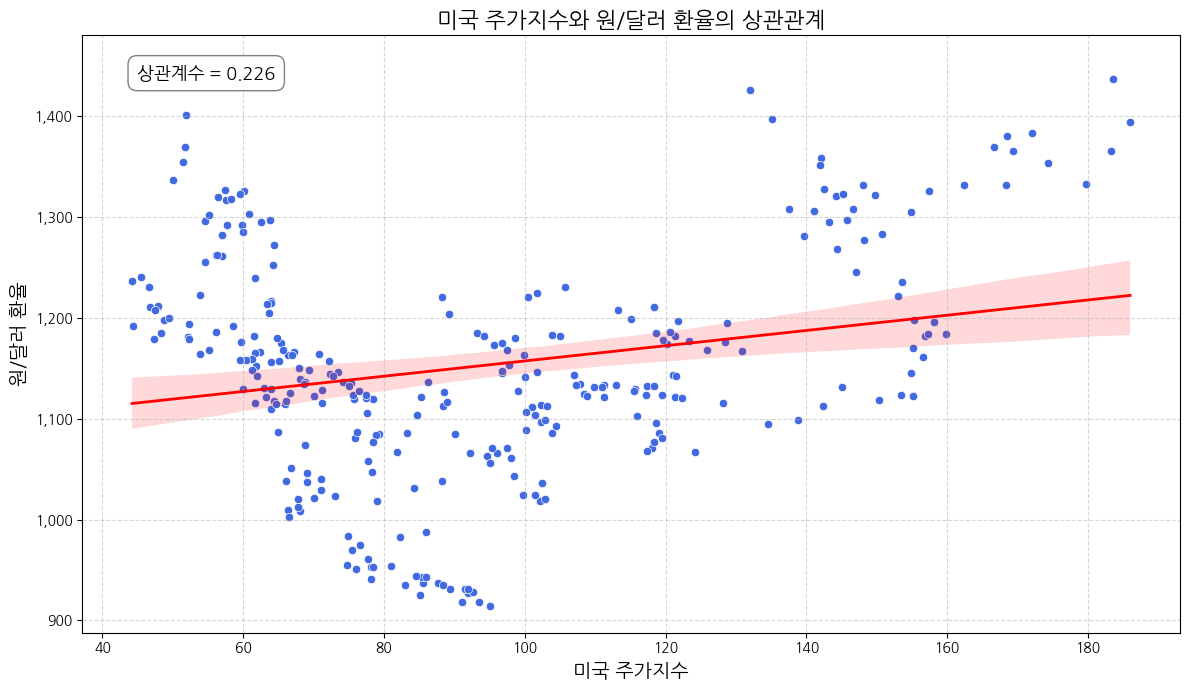

In [ ]:
from scipy.stats import linregress

# 회귀분석 수행
slope, intercept, r_value, p_value, std_err = linregress(exchange_df['미국 주가지수'], exchange_df['원/달러환율'])

# 콘솔에 기울기, 절편, 결정계수(R²), 상관계수(R) 출력
print(f'기울기 (Slope): {slope:.4f}')
print(f'절편 (Intercept): {intercept:.4f}')
print(f'결정계수 (R²): {r_value**2:.4f}')
print(f'상관계수 (R): {r_value:.4f}')

# 산점도
plt.figure(figsize=(12, 7))
sns.scatterplot(x='미국 주가지수', y='원/달러환율', data=exchange_df, color='royalblue')

# 회귀선 추가
sns.regplot(x='미국 주가지수', y='원/달러환율', data=exchange_df,
            scatter=False, color='red', line_kws={'linewidth': 2})

# 화이트 박스에 상관계수(R)만 표시
corr_text = f'상관계수 = {r_value:.3f}'

# 화이트 박스 표시
plt.text(0.05, 0.95, corr_text,
         fontsize=13, transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='gray'))

import matplotlib.ticker as ticker
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))

# 그래프 설정
plt.title('미국 주가지수와 원/달러 환율의 상관관계', fontsize=16)
plt.xlabel('미국 주가지수', fontsize=14)
plt.ylabel('원/달러 환율', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### **해석!**
**1. p‑value = 0.0001**
- 귀무가설을 기각
- 즉, 두 변수간에 통계적으로 유의미한 선형 관계가 있음

**2. 상관계수 (R) = 0.2260**
- 두 변수 간의 선형관계 강도를 나타내는데, 0.226은 약한 양(+)의 상관

**3. 결정계수 (R²) = 0.0511**
- 모델이 환율 변동의 약 **5.11%**만 설명
- 설명력이 약함


## **주요 사건을 중심으로 추론통계 진행**

### **독립표본 t-검정 (시점 비교)**

**1. 가설**
- 귀무가설 : 두 집단 평균이 같다.

**2. pre_event, post_event**
- pre_event는 주요 사건 연도 이전의 환율 샘플
- post_event는 주요 사건 연도 이후의 환율 샘플

**3. 해석**
- t-statistic = -9.505
  - 음수라는 것은 첫 번째 집단(pre_event)의 평균이 두 번째 집단(post_event)의 평균보다 유의하게 낮음
- p-value ≈ 0.0000
  - “팬데믹 전후 평균 환율이 같다”는 주장은 통계적으로 받아들일 수 없음

In [ ]:
import matplotlib.dates as mdates
# 연도, 분기 컬럼 생성
stock_df['연도'] = stock_df['TIME'].dt.year
stock_df['분기'] = stock_df['TIME'].dt.quarter

# 분기별 상관계수 계산
records = []

for (y, q), group in stock_df.groupby(['연도', '분기']):
    if len(group) >= 2:
        r = group['미국 주가지수'].corr(group['원/달러환율'])
        records.append({'연도': y, '분기': f'Q{q}', '상관계수': r})

In [ ]:
# 코로나 (2020년) 이전과 이후 환율 비교
pre_event = stock_df[stock_df['연도'] < 2020]['원/달러환율']
post_event = stock_df[stock_df['연도'] >= 2020]['원/달러환율']

from scipy.stats import ttest_ind
t_stat, p_val = ttest_ind(pre_event, post_event, equal_var=False)
print(f't-statistic: {t_stat:.3f}, p-value: {p_val:.4f}')


t-statistic: -9.497, p-value: 0.0000


## **정상성 검정 ADF**

**1. 해석**
- p < 0.05: 정상성 있음 → 그대로 사용 가능
- p ≥ 0.05: 비정상 → 차분 후 사용해야 함

**2. 변수 → 둘 다 diff 적용해야함**
- 주가 지수
- 원/달러 환율

In [ ]:
from statsmodels.tsa.stattools import adfuller

adf_kospi = adfuller(exchange_df['미국 주가지수'].dropna())
adf_usdkrw = adfuller(exchange_df['원/달러환율'].dropna())
print(f'ADF 주가지수 p-value: {adf_kospi[1]:.4f}')
print(f'ADF 환율 p-value: {adf_usdkrw[1]:.4f}')

ADF 주가지수 p-value: 0.9807
ADF 환율 p-value: 0.4209


### **Cross-Correlation (교차 상관)**
**1. 정의**
- 두 시계열 데이터가 시간차(lag)만큼 이동했을 때 상관계수

- 시계열 간의 선행·후행 관계, 즉 어느 변수가 다른 변수보다 먼저 움직이는지를 파악 가능

**2. 고려 사항**
- 비정상성(non-stationarity): 두 시계열 모두 **평균·분산이 일정해야** 의미 있는 결과

- 과적합 위험: 너무 많은 지연을 고려하면 의미 없는 노이즈가 포함될 수 있음

**3. Lags(시차) : ±12개월**
- 분기별, 월별, 계절별 패턴이 존재할 수 있으니 파악하기 위해 1년을 기준으로 설정

#### **원본 데이터 (비정상성)**

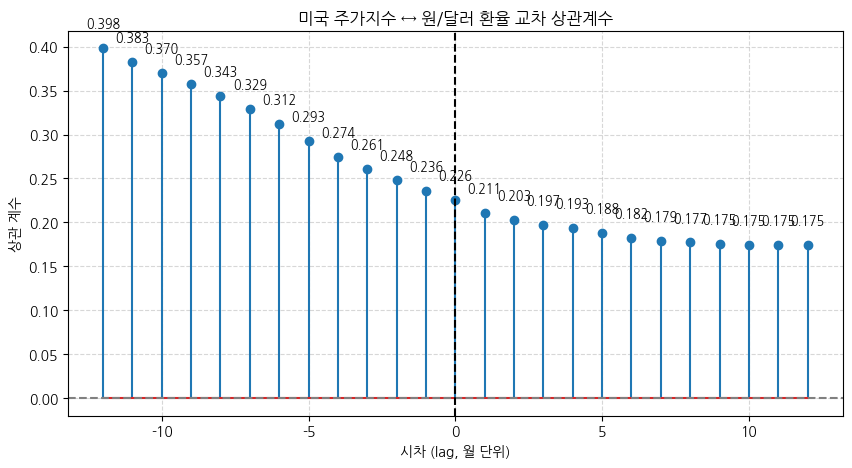

In [ ]:
from statsmodels.tsa.stattools import ccf

lags = range(-12,13)
cc = [exchange_df['원/달러환율'].corr(exchange_df['미국 주가지수'].shift(-lag))
      for lag in lags]

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.stem(lags, cc)
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--')
plt.xlabel('시차 (lag, 월 단위)')
plt.ylabel('상관 계수')
plt.title('미국 주가지수 ↔ 원/달러 환율 교차 상관계수')
plt.grid(True, linestyle='--', alpha=0.5)
# 수치 표시
for x, y in zip(lags, cc):
    plt.text(x, y + 0.02, f"{y:.3f}", ha='center', va='bottom', fontsize=9)
plt.show()


#### **정상성을 적용한 데이터 (월간 변화량)**

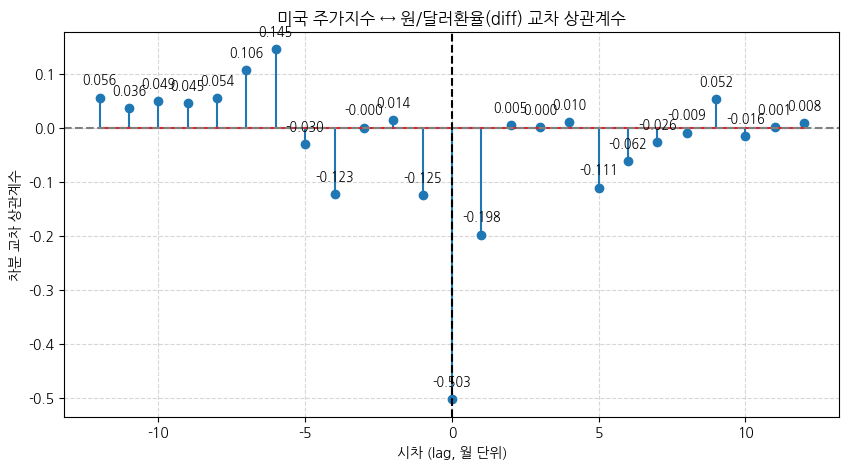

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 차분 계산
df = exchange_df.copy()
df['krw_diff'] = df['원/달러환율'].diff()
df['usidx_diff'] = df['미국 주가지수'].diff()
df = df.dropna(subset=['krw_diff','usidx_diff'])

# lag별 교차상관계수 계산 (diff)
lags = range(-12, 13)
cc_diff = [
    df['krw_diff'].corr(df['usidx_diff'].shift(-lag))
    for lag in lags
]

# 그래프 출력
plt.figure(figsize=(10, 5))
plt.stem(lags, cc_diff)
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--')
plt.xlabel('시차 (lag, 월 단위)')
plt.ylabel('차분 교차 상관계수')
plt.title('미국 주가지수 ↔ 원/달러환율(diff) 교차 상관계수')
plt.grid(True, linestyle='--', alpha=0.5)

# 수치 표시
for x, y in zip(lags, cc_diff):
    plt.text(x, y + 0.02, f"{y:.3f}", ha='center', va='bottom', fontsize=9)

plt.show()

### **해석!**
**1. 기준**
- 그래프 중앙 lag0은 동일한 시점의 외국인 투자 금액과 원/달러 환율의 상관관계를 의미

**2. 왼쪽 구간 (lag<0) : 환율 선행 (환율이 먼저 발생)**
- lag = -6에서 0.145 제일 높은 상관관계를 보임
- 6개월 전 환율 상승 → 미국 주가지수 증가

**3. 오른쪽 구간 (lag>0) : 미국 주가지수 선행 (미국 주가지수가 먼저 발생)**
- lag = +9에서 0.052 상관관계를 보임
- 9개월 전 미국 주가지수 증가 → 환율 상승

### **Granger 인과검정**
**1. 정의**
- 과거의 한 변수 값이 다른 변수의 미래 값을 예측하는 데 통계적으로 유의미한 정보를 제공하는지”를 검정하는 방법

**2. 귀무·대립가설**
- 귀무가설(H₀): 변수 X의 과거 정보가 Y의 미래 값을 예측하는 데 도움이 되지 않는다.
- 대립가설(H₁): 변수 X의 과거 정보가 Y 예측에 유의미하게 기여한다.

- 과적합 위험: 너무 많은 지연을 고려하면 의미 없는 노이즈가 포함될 수 있음

**3. Lags(시차) : ±12개월**
- 분기별, 월별, 계절별 패턴이 존재할 수 있으니 파악하기 위해 1년을 기준으로 설정

**4. 해석**
- “X를 알면 Y를 예측하는 데 도움이 된다/안 된다”로 이해해야 한다.

In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

# 1) Granger 인과검정 실행
data = exchange_df[['원/달러환율','미국 주가지수']].dropna()
max_lag = 9
results = grangercausalitytests(data, maxlag=max_lag, verbose=False)

# 2) 결과를 리스트에 수집
rows = []
for lag, res in results.items():
    f_stat, p_value, _, _ = res[0]['ssr_ftest']  # ssr based F test
    rows.append({
        'lag': lag,
        'F-statistic': round(f_stat, 4),
        'p-value': round(p_value, 4),
        '유의 여부 (p<0.05)': p_value < 0.05
    })

# 3) DataFrame으로 변환 후 출력
df_gc = pd.DataFrame(rows).set_index('lag')
display(df_gc)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


,F-statistic,p-value,유의 여부 (p<0.05)
lag,,,
1,6.2524,0.0129,True
2,3.3847,0.0352,True
3,3.1118,0.0267,True
4,2.4263,0.0482,True
5,3.5120,0.0043,True
6,3.0039,0.0073,True
7,2.8953,0.0062,True
8,2.7916,0.0055,True
9,2.5348,0.0083,True


### 해석!
1. “미국 주가지수의 과거 1~9개월 값을 알면 환율을 예측한다”고 결론

2. F‑statistic 값이 클수록 모형 내에서 추가된 X(주가지수)의 기여도가 더 크다는 뜻이며, lag=1~2 구간에서 특히 F가 높은 편이다.

-> 미국 주가지수가 상승하면 이후 환율이 상승한다”는 가설을 예측 가능성(predictability)의 관점에서 지지

### **다중공선성**

상관계수 매트릭스:
           한국 주가지수   미국 주가지수
한국 주가지수  1.000000  0.871355
미국 주가지수  0.871355  1.000000


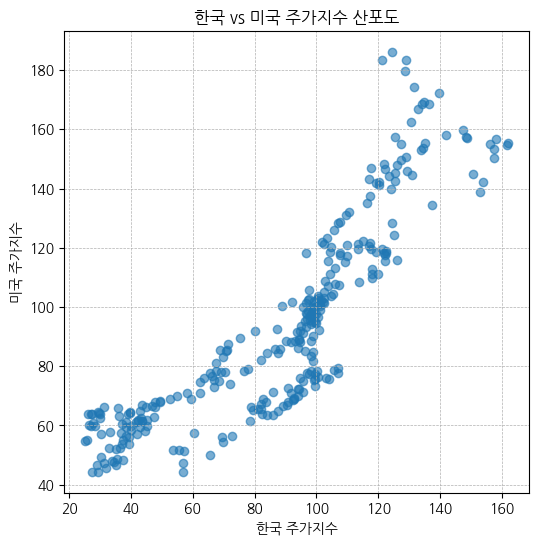


VIF 결과:
      feature       VIF
0    한국 주가지수  4.153861
1    미국 주가지수  4.153861
2  intercept  8.764233


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1) 필요한 컬럼만 추출＆결측치 제거
df_mc = exchange_df[['한국 주가지수', '미국 주가지수']].dropna()

# 2) 상관계수 확인
corr = df_mc.corr()
print("상관계수 매트릭스:\n", corr)

# (옵션) 산포도로 시각화
plt.figure(figsize=(6, 6))
plt.scatter(df_mc['한국 주가지수'], df_mc['미국 주가지수'], alpha=0.6)
plt.xlabel('한국 주가지수')
plt.ylabel('미국 주가지수')
plt.title('한국 vs 미국 주가지수 산포도')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

# 3) VIF 계산
#    VIF는 설명변수에 intercept(상수항)가 있어야 하므로 상수항 컬럼 추가
X = df_mc.copy()
X['intercept'] = 1.0

vif_data = pd.DataFrame({
    'feature': X.columns,
    'VIF': [variance_inflation_factor(X.values, i)
            for i in range(X.shape[1])]
})

print("\nVIF 결과:\n", vif_data)


# **[국채수익률]**

## **가설3 : 한국의 국채 수익률이 높을수록 원화가 강세를 보여 원/달러 환율이 낮아질 것이다.**
- 한국 10년물 국채 수익률이 상승할수록 채권 투자 매력이 높아져
- 외국인·내국인 투자자들이 원화를 더 많이 사게 되고,
- 그 결과 원/달러 환율이 하락(원화 강세)할 것이다.

In [ ]:
file_path = "/content/drive/MyDrive/LikeLion/DataTone/exchange_add_debt.csv"

df2 = pd.read_csv(file_path)
df2.head()

,TIME,원/달러환율,한국 장기 시장 금리,미국 장기 시장 금리,중국 장기 시장 금리,한국 단기 시장 금리,미국 단기 시장 금리,중국 단기 시장 금리,전체 수출 총액,미국 수출 총액,...,미국 경제성장률,중국 경제성장률,한국 GDP,미국 GDP,중국 GDP,한국 GDP 디플레이터,한국 중앙정부 부채 비율,미국 중앙정부 부채 비율,한국 10년 채권수익률,미국 10년 채권수익률
0,2000-01-01,1130.32,NaN,6.66,NaN,7.28,5.95,2.72,12162425,2609788,...,0.363,NaN,597801.700000,1.025095e+07,1.223755e+06,67.68900,NaN,33.267642,NaN,NaN
1,2000-02-01,1129.29,NaN,6.52,NaN,7.13,6.01,2.73,12676042,2554310,...,0.849,NaN,595289.458333,1.027853e+07,1.234695e+06,67.88875,NaN,34.865592,NaN,NaN
2,2000-03-01,1115.75,NaN,6.26,NaN,7.00,6.14,2.64,14429703,2946821,...,1.335,NaN,592777.216667,1.030611e+07,1.245635e+06,68.08850,NaN,36.463543,NaN,NaN
3,2000-04-01,1110.01,NaN,5.99,NaN,7.06,6.28,2.64,13522040,2698030,...,1.821,NaN,590264.975000,1.033370e+07,1.256575e+06,68.28825,NaN,38.061493,NaN,NaN
4,2000-05-01,1121.37,NaN,6.44,NaN,7.14,6.71,2.57,14636755,3167181,...,1.248,NaN,587752.733333,1.036128e+07,1.267515e+06,68.48800,NaN,39.659444,NaN,NaN


In [ ]:
debt_df = df2.copy()

## **상관관계 유의성 검정 (피어슨 상관계수)**

1. 귀무가설(H₀)
- 두 변수(한국 국채(10년) 수익률, 원/달러환율) 사이에 선형 상관관계가 없다 (즉, 모상관계수 ρ=0)

2. 대립가설(H₁)
- 두 변수 사이에 선형 상관관계가 있다 (ρ ≠ 0)




In [ ]:
import pandas as pd
from scipy.stats import pearsonr

# 1) 두 시리즈를 하나의 DataFrame에 합치고
df_merged = pd.concat([
    debt_df['한국 10년 채권수익률'],
    exchange_df['원/달러환율']
], axis=1).rename(columns={
    '한국 10년 채권수익률': 'yield10y',
    '원/달러환율':     'usdkrw'
})

# 2) 둘 다 non‑NA인 행만 남기기
df_clean = df_merged.dropna()

# 3) 샘플 수 확인
print("샘플 수:", len(df_clean))

# 4) 분산(variance) 확인 — 상수 시리즈인지 검사
print("yield10y 분산:", df_clean['yield10y'].var())
print("usdkrw   분산:",   df_clean['usdkrw'].var())

# 5) Pearson 상관계수 계산
if len(df_clean) >= 2 and df_clean['yield10y'].var() > 0 and df_clean['usdkrw'].var() > 0:
    corr_coef, p_value = pearsonr(df_clean['yield10y'], df_clean['usdkrw'])
    print(f"p-value = {p_value:.4f}")
else:
    print("샘플이 너무 적거나 분산이 0인 시리즈가 있어 상관계수를 계산할 수 없습니다.")


샘플 수: 290
yield10y 분산: 2.48880346977091
usdkrw   분산: 13296.499440109781
p-value = 0.8292


### **원/달러환율 ~ 한국 국채(10년) 수익률 산점도 및 상관관계**

기울기 (Slope): 0.9300
절편 (Intercept): 1149.9496
결정계수 (R²): 0.0002
상관계수 (R): 0.0127


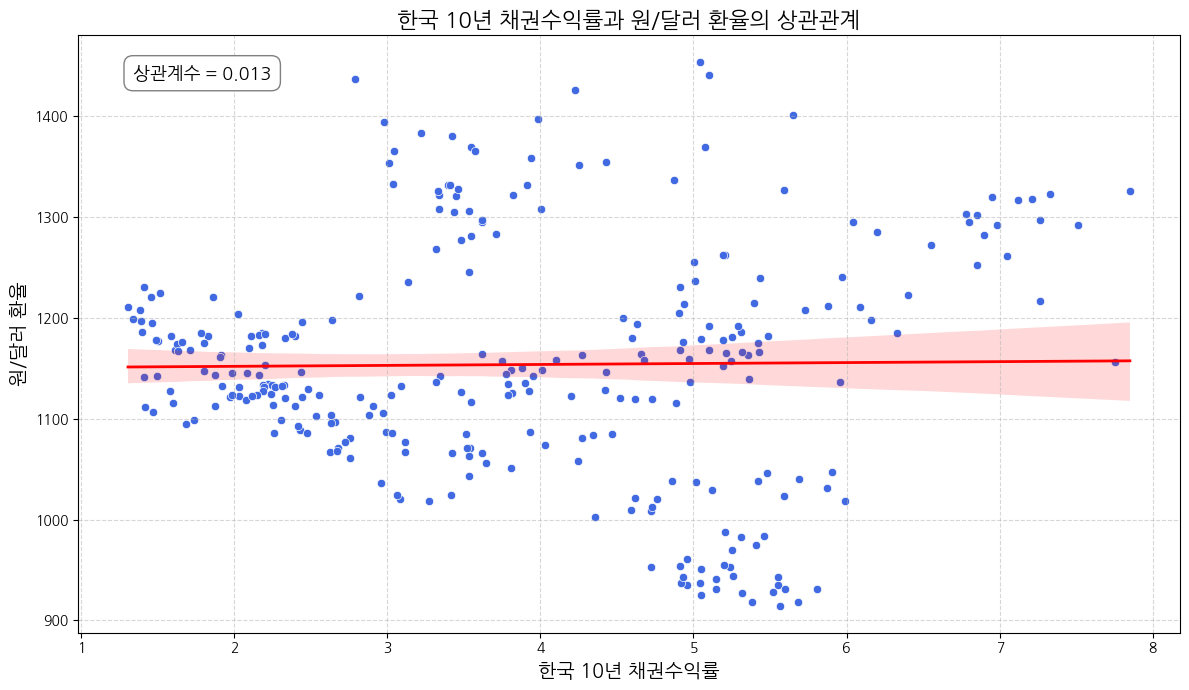

In [ ]:
# 두 데이터프레임에서 필요한 열만 결합
df_corr = pd.concat([
    debt_df[['한국 10년 채권수익률']],
    exchange_df[['원/달러환율']]
], axis=1).dropna()  # 결측치 제거

# 회귀분석 수행
slope, intercept, r_value, p_value, std_err = linregress(df_corr['한국 10년 채권수익률'], df_corr['원/달러환율'])

# 출력
print(f'기울기 (Slope): {slope:.4f}')
print(f'절편 (Intercept): {intercept:.4f}')
print(f'결정계수 (R²): {r_value**2:.4f}')
print(f'상관계수 (R): {r_value:.4f}')

# 시각화
plt.figure(figsize=(12, 7))
sns.scatterplot(x=df_corr['한국 10년 채권수익률'], y=df_corr['원/달러환율'], color='royalblue')
sns.regplot(x=df_corr['한국 10년 채권수익률'], y=df_corr['원/달러환율'],
            scatter=False, color='red', line_kws={'linewidth': 2})

corr_text = f'상관계수 = {r_value:.3f}'
plt.text(0.05, 0.95, corr_text, fontsize=13, transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='gray'))

plt.title('한국 10년 채권수익률과 원/달러 환율의 상관관계', fontsize=16)
plt.xlabel('한국 10년 채권수익률', fontsize=14)
plt.ylabel('원/달러 환율', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### **해석!**
**1. p-value = 0.8292**
- 귀무가설(ρ = 0, 즉 상관관계가 없다)을 기각할 수 없습니다.
다시 말해, “수익률이 높아질수록 환율이 낮아진다”는 선형관계가 통계적으로 검증되지 않았다.

**2. 결정계수(R²): 0.0002**
- 회귀모형이 환율의 분산 중 0.02%만 설명함 → 설명력 거의 없음

- 10년 채권수익률이 환율의 움직임을 설명할 수 있는 능력은 매우 낮다.

**3. 상관계수 : 0.0127**

- 두 변수 사이의 선형 상관성 거의 없음 (0에 가까움)

**→ 한국 10년 채권수익률과 원/달러 환율 사이에는 통계적으로 유의한 선형 관계가 없다고 해석된다.**

## **정상성 검정 ADF**

**1. 해석**
- p < 0.05: 정상성 있음 → 그대로 사용 가능
- p ≥ 0.05: 비정상 → 차분 후 사용해야 함

**2. 변수 → 둘 다 diff 적용해야함**
- 주가 지수
- 원/달러 환율

In [ ]:
from statsmodels.tsa.stattools import adfuller

adf_kospi = adfuller(debt_df['한국 10년 채권수익률'].dropna())
adf_usdkrw = adfuller(exchange_df['원/달러환율'].dropna())
print(f'ADF 주가지수 p-value: {adf_kospi[1]:.4f}')
print(f'ADF 환율 p-value: {adf_usdkrw[1]:.4f}')

ADF 주가지수 p-value: 0.3042
ADF 환율 p-value: 0.4209


### **Cross-Correlation (교차 상관)**

#### **원본 데이터 (비정상성)**

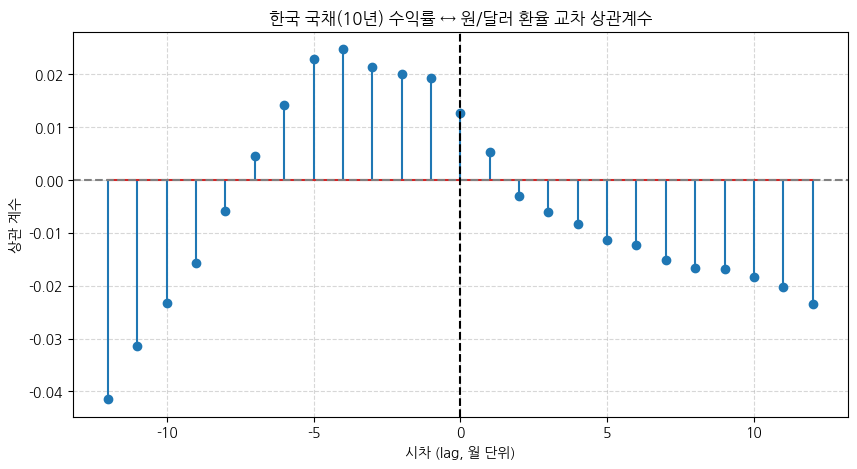

In [ ]:
from statsmodels.tsa.stattools import ccf

lags = range(-12,13)
cc = [exchange_df['원/달러환율'].corr(debt_df['한국 10년 채권수익률'].shift(-lag))
      for lag in lags]

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.stem(lags, cc)
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--')
plt.xlabel('시차 (lag, 월 단위)')
plt.ylabel('상관 계수')
plt.title('한국 국채(10년) 수익률 ↔ 원/달러 환율 교차 상관계수')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [ ]:
# DataFrame 으로 정리
df_cc = pd.DataFrame({
    'lag (월)': lags,
    'corr (diff)': cc
})
display(df_cc)

,lag (월),corr (diff)
0,-12,-0.041461
1,-11,-0.031416
2,-10,-0.023322
3,-9,-0.015732
4,-8,-0.005812
5,-7,0.004495
6,-6,0.014143
7,-5,0.022863
8,-4,0.024730
9,-3,0.021418


#### **정상성을 적용한 데이터 (월간 변화량)**

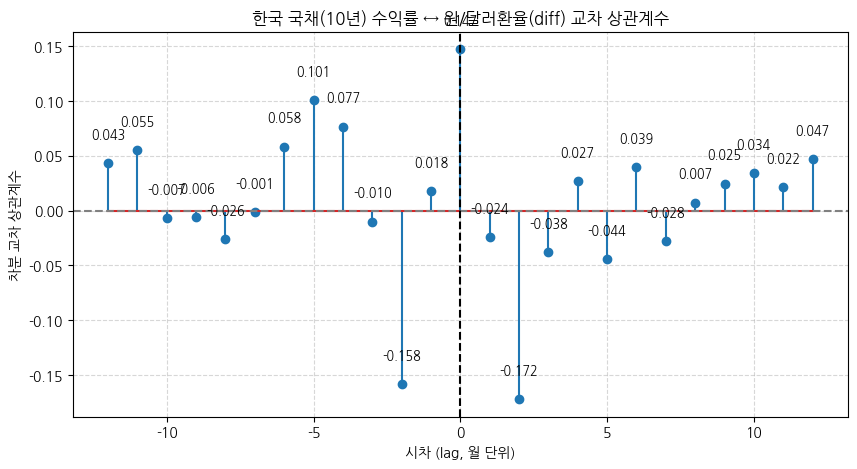

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 차분 계산
df = debt_df.copy()
df['krw_diff'] = df['원/달러환율'].diff()
df['usidx_diff'] = df['한국 10년 채권수익률'].diff()
df = df.dropna(subset=['krw_diff','usidx_diff'])

# lag별 교차상관계수 계산 (diff)
lags = range(-12, 13)
cc_diff = [
    df['krw_diff'].corr(df['usidx_diff'].shift(-lag))
    for lag in lags
]

# 그래프 출력
plt.figure(figsize=(10, 5))
plt.stem(lags, cc_diff)
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--')
plt.xlabel('시차 (lag, 월 단위)')
plt.ylabel('차분 교차 상관계수')
plt.title('한국 국채(10년) 수익률 ↔ 원/달러환율(diff) 교차 상관계수')
plt.grid(True, linestyle='--', alpha=0.5)

# 수치 표시
for x, y in zip(lags, cc_diff):
    plt.text(x, y + 0.02, f"{y:.3f}", ha='center', va='bottom', fontsize=9)

plt.show()

### **해석!**
**1. 기준**
- 그래프 중앙 lag0은 동일한 시점의 외국인 투자 금액과 원/달러 환율의 상관관계를 의미

**2. 왼쪽 구간 (lag<0) : 환율 선행 (환율이 먼저 발생)**
- lag = -2에서 -0.158 제일 높은 상관관계를 보임
- 2개월 전 환율 상승 → 한국 국채(10년) 수익률 하락

**3. 오른쪽 구간 (lag>0) : 한국 국채(10년) 수익률 선행 (한국 국채(10년) 수익률이 먼저 발생)**
- lag = +2에서 -0.172 상관관계를 보임
- 2개월 전 한국 국채(10년) 수익률 하락 → 환율 상승

### **Granger 인과검정**
**1. 정의**
- 과거의 한 변수 값이 다른 변수의 미래 값을 예측하는 데 통계적으로 유의미한 정보를 제공하는지”를 검정하는 방법

**2. 귀무·대립가설**
- 귀무가설(H₀): 변수 X의 과거 정보가 Y의 미래 값을 예측하는 데 도움이 되지 않는다.
- 대립가설(H₁): 변수 X의 과거 정보가 Y 예측에 유의미하게 기여한다.

- 과적합 위험: 너무 많은 지연을 고려하면 의미 없는 노이즈가 포함될 수 있음

**3. Lags(시차) : ±12개월**
- 분기별, 월별, 계절별 패턴이 존재할 수 있으니 파악하기 위해 1년을 기준으로 설정

**4. 해석**
- “X를 알면 Y를 예측하는 데 도움이 된다/안 된다”로 이해해야 한다.

In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

# 1) Granger 인과검정 실행
data = debt_df[['원/달러환율','한국 10년 채권수익률']].dropna()
max_lag = 2
results = grangercausalitytests(data, maxlag=max_lag, verbose=False)

# 2) 결과를 리스트에 수집
rows = []
for lag, res in results.items():
    f_stat, p_value, _, _ = res[0]['ssr_ftest']  # ssr based F test
    rows.append({
        'lag': lag,
        'F-statistic': round(f_stat, 4),
        'p-value': round(p_value, 4),
        '유의 여부 (p<0.05)': p_value < 0.05
    })

# 3) DataFrame으로 변환 후 출력
df_gc = pd.DataFrame(rows).set_index('lag')
display(df_gc)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


,F-statistic,p-value,유의 여부 (p<0.05)
lag,,,
1,0.0058,0.9392,False
2,0.4591,0.6323,False


### **해석!**
1. 한국 10년 채권수익률의 과거 1~2개월 값을 알아도 환율을 예측할 수 없다"고 결론

-> 한국 10년 채권수익률이 상승하면 이후 환율이 하락한다”는 가설을 예측 가능성(predictability)의 관점에서 지지할 수 없음

## **가설4 : 미국의 국채 수익률이 높을수록 달러가 강세를 보여 원/달러 환율이 높아질 것이다.**
- 미국 10년물 국채 수익률이 상승할수록 미국의 채권 투자 매력이 높아져
- 투자자들이 달러를 더 많이 사게 되고,
- 그 결과 원/달러 환율이 상승(원화 약세)할 것이다.

## **상관관계 유의성 검정 (피어슨 상관계수)**

1. 귀무가설(H₀)
- 두 변수(한국 국채(10년) 수익률, 원/달러환율) 사이에 선형 상관관계가 없다 (즉, 모상관계수 ρ=0)

2. 대립가설(H₁)
- 두 변수 사이에 선형 상관관계가 있다 (ρ ≠ 0)




In [ ]:
import pandas as pd
from scipy.stats import pearsonr

# 1) 두 시리즈를 하나의 DataFrame에 합치고
df_merged = pd.concat([
    debt_df['미국 10년 채권수익률'],
    exchange_df['원/달러환율']
], axis=1).rename(columns={
    '미국 10년 채권수익률': 'yield10y',
    '원/달러환율':     'usdkrw'
})

# 2) 둘 다 non‑NA인 행만 남기기
df_clean = df_merged.dropna()

# 3) 샘플 수 확인
print("샘플 수:", len(df_clean))

# 4) 분산(variance) 확인 — 상수 시리즈인지 검사
print("yield10y 분산:", df_clean['yield10y'].var())
print("usdkrw   분산:",   df_clean['usdkrw'].var())

# 5) Pearson 상관계수 계산
if len(df_clean) >= 2 and df_clean['yield10y'].var() > 0 and df_clean['usdkrw'].var() > 0:
    corr_coef, p_value = pearsonr(df_clean['yield10y'], df_clean['usdkrw'])
    print(f"p-value = {p_value:.4f}")
else:
    print("샘플이 너무 적거나 분산이 0인 시리즈가 있어 상관계수를 계산할 수 없습니다.")


샘플 수: 290
yield10y 분산: 1.700258446653144
usdkrw   분산: 13296.499440109781
p-value = 0.9286


### **원/달러환율 ~ 미국 국채(10년) 수익률 산점도 및 상관관계**

기울기 (Slope): 0.4671
절편 (Intercept): 1152.0485
결정계수 (R²): 0.0000
상관계수 (R): 0.0053


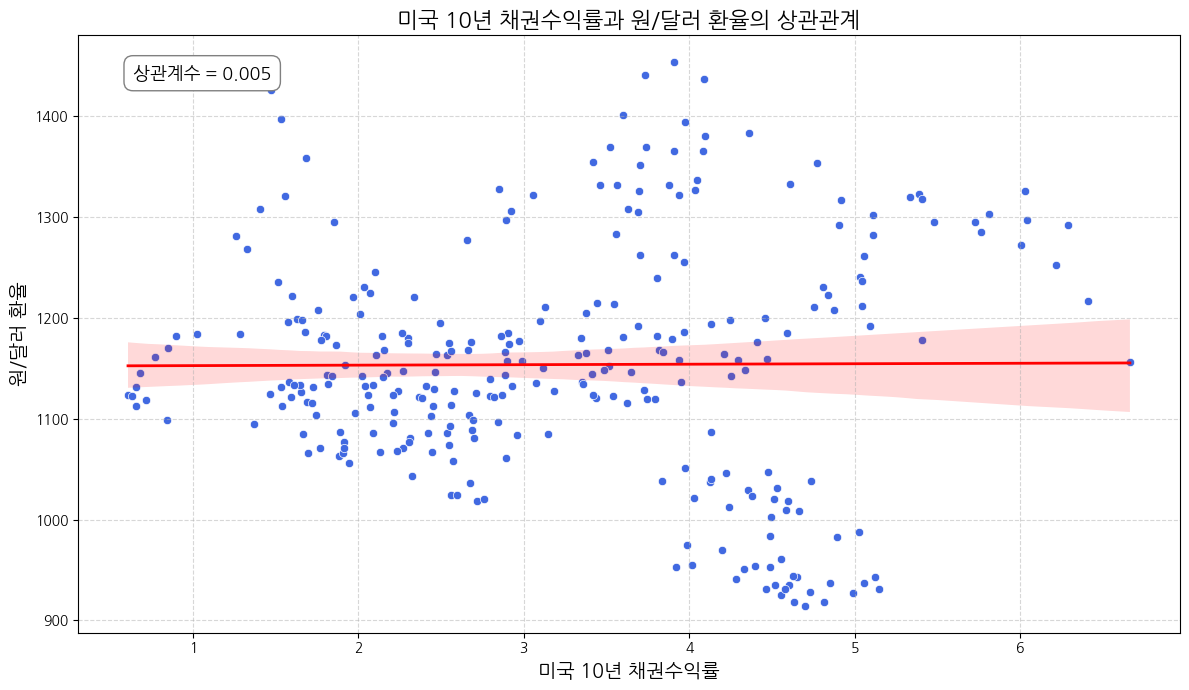

In [ ]:
# 두 데이터프레임에서 필요한 열만 결합
df_corr = pd.concat([
    debt_df[['미국 10년 채권수익률']],
    exchange_df[['원/달러환율']]
], axis=1).dropna()  # 결측치 제거

# 회귀분석 수행
slope, intercept, r_value, p_value, std_err = linregress(df_corr['미국 10년 채권수익률'], df_corr['원/달러환율'])

# 출력
print(f'기울기 (Slope): {slope:.4f}')
print(f'절편 (Intercept): {intercept:.4f}')
print(f'결정계수 (R²): {r_value**2:.4f}')
print(f'상관계수 (R): {r_value:.4f}')

# 시각화
plt.figure(figsize=(12, 7))
sns.scatterplot(x=df_corr['미국 10년 채권수익률'], y=df_corr['원/달러환율'], color='royalblue')
sns.regplot(x=df_corr['미국 10년 채권수익률'], y=df_corr['원/달러환율'],
            scatter=False, color='red', line_kws={'linewidth': 2})

corr_text = f'상관계수 = {r_value:.3f}'
plt.text(0.05, 0.95, corr_text, fontsize=13, transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='gray'))

plt.title('미국 10년 채권수익률과 원/달러 환율의 상관관계', fontsize=16)
plt.xlabel('미국 10년 채권수익률', fontsize=14)
plt.ylabel('원/달러 환율', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### **해석!**
**1. p-value = 0.9286**
- 귀무가설(ρ = 0, 즉 상관관계가 없다)을 기각할 수 없음
다시 말해, “수익률이 높아질수록 환율이 높아진다”는 선형관계가 통계적으로 검증되지 않았다.

**2. 결정계수(R²): 0.0000**
- 회귀모형이 환율의 분산 중 0.0% 설명함 → 설명력 거의 없음

**3. 상관계수 : 0.0053**
- 10년 채권수익률이 환율의 움직임을 설명할 수 있는 능력은 매우 낮다.
- 두 변수 사이의 선형 상관성 거의 없음 (0에 가까움)

**→ 미국 10년 채권수익률과 원/달러 환율 사이에는 통계적으로 유의한 선형 관계가 없다고 해석된다.**

## **정상성 검정 ADF**

**1. 해석**
- p < 0.05: 정상성 있음 → 그대로 사용 가능
- p ≥ 0.05: 비정상 → 차분 후 사용해야 함

**2. 변수 → 둘 다 diff 적용해야함**
- 주가 지수
- 원/달러 환율

In [ ]:
from statsmodels.tsa.stattools import adfuller

adf_kospi = adfuller(debt_df['미국 10년 채권수익률'].dropna())
adf_usdkrw = adfuller(exchange_df['원/달러환율'].dropna())
print(f'ADF 미국 채권수익률 p-value: {adf_kospi[1]:.4f}')
print(f'ADF 환율 p-value: {adf_usdkrw[1]:.4f}')

ADF 미국 채권수익률 p-value: 0.0998
ADF 환율 p-value: 0.4209


### **Cross-Correlation (교차 상관)**

#### **원본 데이터 (비정상성)**

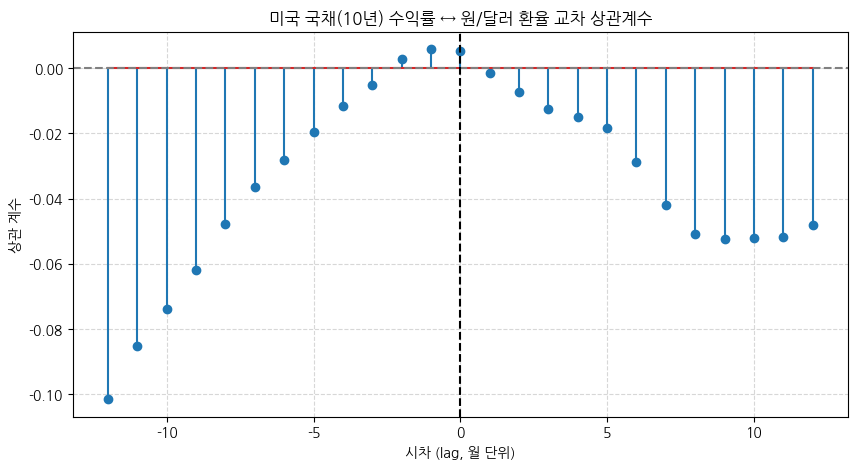

In [ ]:
from statsmodels.tsa.stattools import ccf

lags = range(-12,13)
cc = [exchange_df['원/달러환율'].corr(debt_df['미국 10년 채권수익률'].shift(-lag))
      for lag in lags]

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.stem(lags, cc)
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--')
plt.xlabel('시차 (lag, 월 단위)')
plt.ylabel('상관 계수')
plt.title('미국 국채(10년) 수익률 ↔ 원/달러 환율 교차 상관계수')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [ ]:
# DataFrame 으로 정리
df_cc = pd.DataFrame({
    'lag (월)': lags,
    'corr (diff)': cc
})
display(df_cc)

,lag (월),corr (diff)
0,-12,-0.101513
1,-11,-0.085123
2,-10,-0.073747
3,-9,-0.062036
4,-8,-0.047798
5,-7,-0.036556
6,-6,-0.028221
7,-5,-0.019477
8,-4,-0.011460
9,-3,-0.005035


#### **정상성을 적용한 데이터 (월간 변화량)**

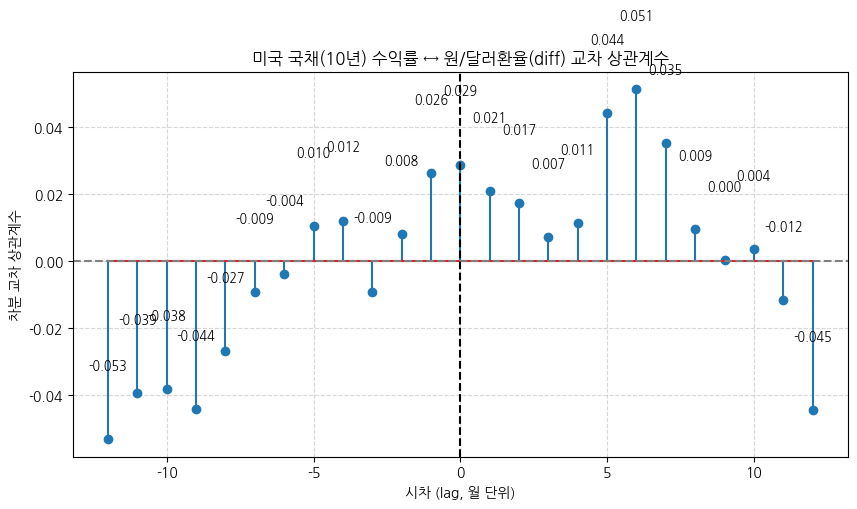

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 차분 계산
df = debt_df.copy()
df['krw_diff'] = df['원/달러환율'].diff()
df = df.dropna(subset=['krw_diff','미국 10년 채권수익률'])

# lag별 교차상관계수 계산 (diff)
lags = range(-12, 13)
cc_diff = [
    df['krw_diff'].corr(df['미국 10년 채권수익률'].shift(-lag))
    for lag in lags
]

# 그래프 출력
plt.figure(figsize=(10, 5))
plt.stem(lags, cc_diff)
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--')
plt.xlabel('시차 (lag, 월 단위)')
plt.ylabel('차분 교차 상관계수')
plt.title('미국 국채(10년) 수익률 ↔ 원/달러환율(diff) 교차 상관계수')
plt.grid(True, linestyle='--', alpha=0.5)

# 수치 표시
for x, y in zip(lags, cc_diff):
    plt.text(x, y + 0.02, f"{y:.3f}", ha='center', va='bottom', fontsize=9)

plt.show()

### **해석!**
**1. 기준**
- 그래프 중앙 lag0은 동일한 시점의 미국 국채 수익률과 원/달러 환율의 상관관계를 의미

**2. 왼쪽 구간 (lag<0) : 환율 선행 (환율이 먼저 발생)**
- lag = -12에서 -0.053 제일 높은 상관관계를 보임
- 12개월 전 환율 상승 → 미국 국채(10년) 수익률 하락

**3. 오른쪽 구간 (lag>0) : 미국 국채(10년) 수익률 선행 (미국 국채(10년) 수익률이 먼저 발생)**
- lag = +6에서 0.051 상관관계를 보임
- 6개월 전 미국 국채(10년) 수익률 상승 → 환율 상승

### **Granger 인과검정**
**1. 정의**
- 과거의 한 변수 값이 다른 변수의 미래 값을 예측하는 데 통계적으로 유의미한 정보를 제공하는지”를 검정하는 방법

**2. 귀무·대립가설**
- 귀무가설(H₀): 변수 X의 과거 정보가 Y의 미래 값을 예측하는 데 도움이 되지 않는다.
- 대립가설(H₁): 변수 X의 과거 정보가 Y 예측에 유의미하게 기여한다.

- 과적합 위험: 너무 많은 지연을 고려하면 의미 없는 노이즈가 포함될 수 있음

**3. Lags(시차) : ±12개월**
- 분기별, 월별, 계절별 패턴이 존재할 수 있으니 파악하기 위해 1년을 기준으로 설정

**4. 해석**
- “X를 알면 Y를 예측하는 데 도움이 된다/안 된다”로 이해해야 한다.

In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

# 1) Granger 인과검정 실행
data = debt_df[['원/달러환율','미국 10년 채권수익률']].dropna()
max_lag = 6
results = grangercausalitytests(data, maxlag=max_lag, verbose=False)

# 2) 결과를 리스트에 수집
rows = []
for lag, res in results.items():
    f_stat, p_value, _, _ = res[0]['ssr_ftest']  # ssr based F test
    rows.append({
        'lag': lag,
        'F-statistic': round(f_stat, 4),
        'p-value': round(p_value, 4),
        '유의 여부 (p<0.05)': p_value < 0.05
    })

# 3) DataFrame으로 변환 후 출력
df_gc = pd.DataFrame(rows).set_index('lag')
display(df_gc)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


,F-statistic,p-value,유의 여부 (p<0.05)
lag,,,
1,0.1967,0.6577,False
2,0.0021,0.9979,False
3,0.0415,0.9887,False
4,0.5892,0.6707,False
5,0.4215,0.8336,False
6,0.3835,0.8893,False


### **해석!**
1. 미국 10년 채권수익률의 과거 1~6개월 값을 알아도 환율을 예측할 수 없다"고 결론

-> 미국 10년 채권수익률이 상승하면 이후 환율이 상승한다”는 가설을 예측 가능성(predictability)의 관점에서 지지할 수 없음

### **다중공선성**

상관계수 매트릭스:
               한국 10년 채권수익률  미국 10년 채권수익률
한국 10년 채권수익률      1.000000      0.814909
미국 10년 채권수익률      0.814909      1.000000


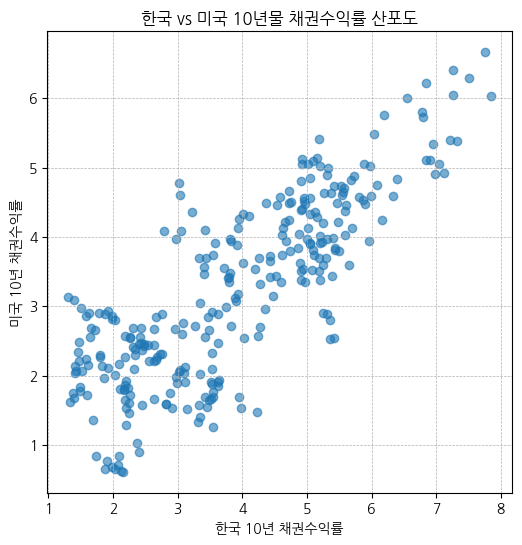


VIF 결과:
         feature       VIF
0  한국 10년 채권수익률  2.976867
1  미국 10년 채권수익률  2.976867
2     intercept  7.719874


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1) 필요한 컬럼만 추출＆결측치 제거
df_mc = debt_df[['한국 10년 채권수익률', '미국 10년 채권수익률']].dropna()

# 2) 상관계수 확인
corr = df_mc.corr()
print("상관계수 매트릭스:\n", corr)

# (옵션) 산포도로 시각화
plt.figure(figsize=(6, 6))
plt.scatter(df_mc['한국 10년 채권수익률'], df_mc['미국 10년 채권수익률'], alpha=0.6)
plt.xlabel('한국 10년 채권수익률')
plt.ylabel('미국 10년 채권수익률')
plt.title('한국 vs 미국 10년물 채권수익률 산포도')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

# 3) VIF 계산
#    VIF는 설명변수에 intercept(상수항)가 있어야 하므로 상수항 컬럼 추가
X = df_mc.copy()
X['intercept'] = 1.0

vif_data = pd.DataFrame({
    'feature': X.columns,
    'VIF': [variance_inflation_factor(X.values, i)
            for i in range(X.shape[1])]
})

print("\nVIF 결과:\n", vif_data)


한국 10년 채권수익률 (VIF ≈ 2.98)

미국 10년 채권수익률 (VIF ≈ 2.98)

두 변수 모두 VIF가 3 미만이므로, 서로 어느 정도 상관은 있지만 “심각할 정도”로 겹치지는 않습니다.

즉, 회귀에 함께 투입해도 계수 추정이 크게 불안정해지진 않을 것으로 보입니다.

intercept (절편, VIF ≈ 7.72)

절편에 대해서는 VIF 해석이 크게 의미가 없습니다. (상수항이 모든 관측치에 동일 값을 가짐)

보통은 설명 변수들만 보고 다중공선성을 평가합니다.

# **[정부부채비율]**

## **가설5 : 한국의 정부부채비율이 높을수록 원화가 약세를 보여 원/달러 환율이 높아질 것이다.**
- 한국의 정부부채비율이 높을수록 정부의 재정 건정성에 대한 우려가 발생하고,
- 이로 인해 투자자 신뢰 하락하고, 그 결과, 원화가 약세를 보일 것이다.

## **상관관계 유의성 검정 (피어슨 상관계수)**

1. 귀무가설(H₀)
- 두 변수(한국 국채(10년) 수익률, 원/달러환율) 사이에 선형 상관관계가 없다 (즉, 모상관계수 ρ=0)

2. 대립가설(H₁)
- 두 변수 사이에 선형 상관관계가 있다 (ρ ≠ 0)




In [ ]:
import pandas as pd
from scipy.stats import pearsonr

# 1) 두 시리즈를 하나의 DataFrame에 합치고
df_merged = pd.concat([
    exchange_df['한국 정부 부채 비율'],
    exchange_df['원/달러환율']
], axis=1).rename(columns={
    '한국 정부 부채 비율': 'kordebt',
    '원/달러환율':     'usdkrw'
})

# 2) 둘 다 non‑NA인 행만 남기기
df_clean = df_merged.dropna()

# 3) 샘플 수 확인
print("샘플 수:", len(df_clean))

# 4) 분산(variance) 확인 — 상수 시리즈인지 검사
print("kordebt 분산:", df_clean['kordebt'].var())
print("usdkrw   분산:",   df_clean['usdkrw'].var())

# 5) Pearson 상관계수 계산
if len(df_clean) >= 2 and df_clean['kordebt'].var() > 0 and df_clean['usdkrw'].var() > 0:
    corr_coef, p_value = pearsonr(df_clean['kordebt'], df_clean['usdkrw'])
    print(f"p-value = {p_value:.4f}")
else:
    print("샘플이 너무 적거나 분산이 0인 시리즈가 있어 상관계수를 계산할 수 없습니다.")


샘플 수: 265
kordebt 분산: 103.8279515814536
usdkrw   분산: 9786.788298176101
p-value = 0.1725


### **원/달러환율 ~ 한국 정부 부채 비율 산점도 및 상관관계**

기울기 (Slope): -0.8160
절편 (Intercept): 1156.8101
결정계수 (R²): 0.0071
상관계수 (R): -0.0840


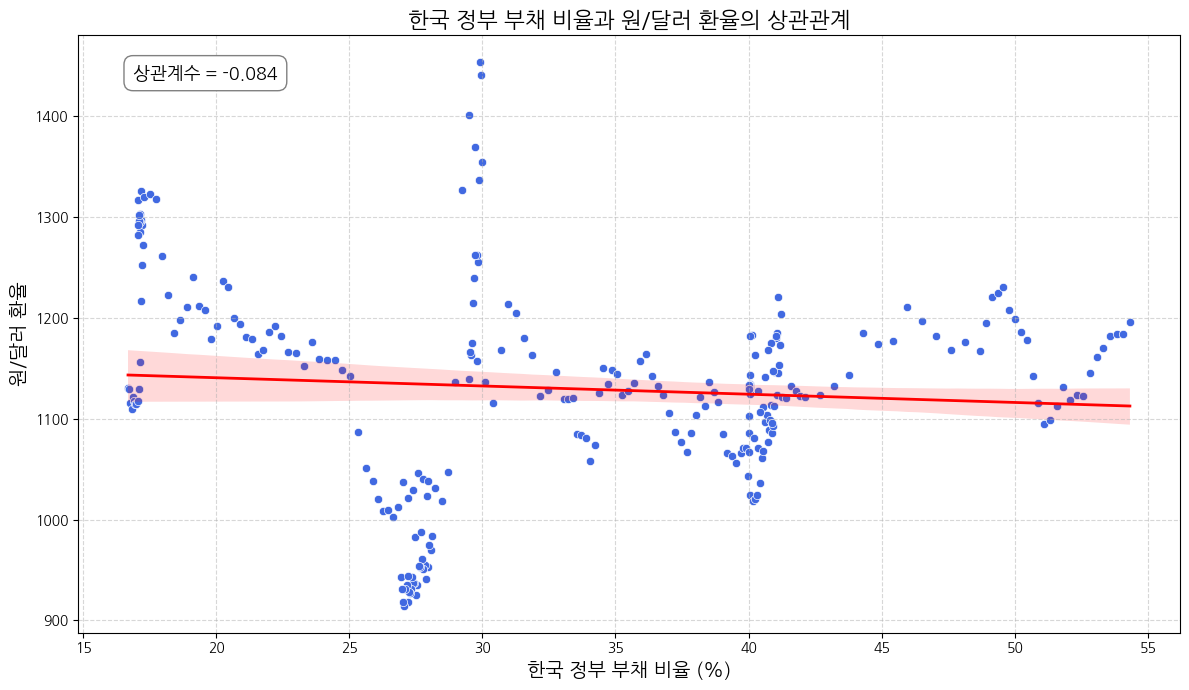

In [ ]:
from scipy.stats import linregress

# 필요한 컬럼만 선택하고 결측치 제거
df_clean = exchange_df[['한국 정부 부채 비율', '원/달러환율']].dropna()

# 회귀분석 수행
slope, intercept, r_value, p_value, std_err = linregress(df_clean['한국 정부 부채 비율'], df_clean['원/달러환율'])

# 콘솔에 결과 출력
print(f'기울기 (Slope): {slope:.4f}')
print(f'절편 (Intercept): {intercept:.4f}')
print(f'결정계수 (R²): {r_value**2:.4f}')
print(f'상관계수 (R): {r_value:.4f}')

# 산점도 및 회귀선
plt.figure(figsize=(12, 7))
sns.scatterplot(x='한국 정부 부채 비율', y='원/달러환율', data=df_clean, color='royalblue')
sns.regplot(x='한국 정부 부채 비율', y='원/달러환율', data=df_clean,
            scatter=False, color='red', line_kws={'linewidth': 2})

# 상관계수 박스
corr_text = f'상관계수 = {r_value:.3f}'
plt.text(0.05, 0.95, corr_text,
         fontsize=13, transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='gray'))

# 그래프 설정
plt.title('한국 정부 부채 비율과 원/달러 환율의 상관관계', fontsize=16)
plt.xlabel('한국 정부 부채 비율 (%)', fontsize=14)
plt.ylabel('원/달러 환율', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### **해석!**
**1. p-value = 0.1725**
-  0.1725 > 0.05 : 귀무가설 기각하지 않음
- 두 변수간의 선형관계는 없다고 판단

**2. 결정계수(R²): 0.0071**
- 한국 정부 부채 비율은 환율 변동의 0.71%만 설명
- 정부 부채 비율이 환율의 움직임을 설명할 수 있는 능력은 매우 낮다.

**3. 상관계수 : -0.084**
- 음수지만 매우 작은 값으로, 한국 정부 부채 비율 원/달러 환율 간의 선형적 상관관계는 거의 없음 (낮은 상관관계)

→ 한국의 중앙정부 부채 비율이 증가한다고 해서 환율이 유의미하게 하락하거나 상승하는 경향은 없다고 볼 수 있음

## **정상성 검정 ADF**

**1. 해석**
- p < 0.05: 정상성 있음 → 그대로 사용 가능
- p ≥ 0.05: 비정상 → 차분 후 사용해야 함

**2. 변수 → 둘 다 diff 적용해야함**
- 주가 지수
- 원/달러 환율

In [ ]:
from statsmodels.tsa.stattools import adfuller

adf_kospi = adfuller(exchange_df['한국 정부 부채 비율'].dropna())
adf_usdkrw = adfuller(exchange_df['원/달러환율'].dropna())
print(f'ADF 한국 정부 부채 비율 p-value: {adf_kospi[1]:.4f}')
print(f'ADF 환율 p-value: {adf_usdkrw[1]:.4f}')

ADF 한국 정부 부채 비율 p-value: 0.9467
ADF 환율 p-value: 0.4209


### **Cross-Correlation (교차 상관)**

#### **원본 데이터 (비정상성)**

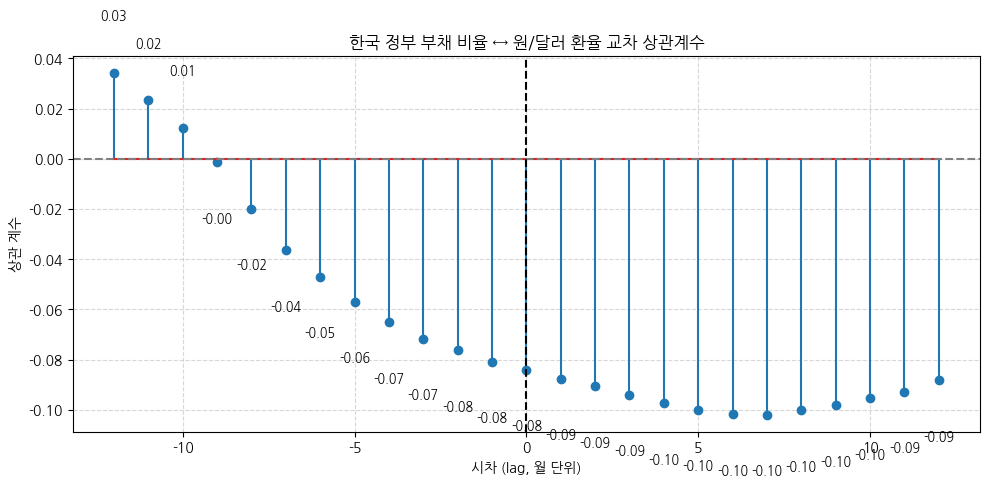

In [ ]:
import matplotlib.pyplot as plt

# 시차 범위
lags = range(-12, 13)

# 교차상관계수 계산
cc = [exchange_df['원/달러환율'].corr(exchange_df['한국 정부 부채 비율'].shift(-lag))
      for lag in lags]

# 시각화
plt.figure(figsize=(10, 5))
markerline, stemlines, baseline = plt.stem(lags, cc)

# 수치 라벨 추가
for lag, coef in zip(lags, cc):
    plt.text(lag, coef + 0.02 * (1 if coef >= 0 else -1), f'{coef:.2f}',
             ha='center', va='bottom' if coef >= 0 else 'top', fontsize=9)

# 보조선
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--')

# 레이아웃
plt.xlabel('시차 (lag, 월 단위)')
plt.ylabel('상관 계수')
plt.title('한국 정부 부채 비율 ↔ 원/달러 환율 교차 상관계수')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


#### **정상성을 적용한 데이터 (월간 변화량)**

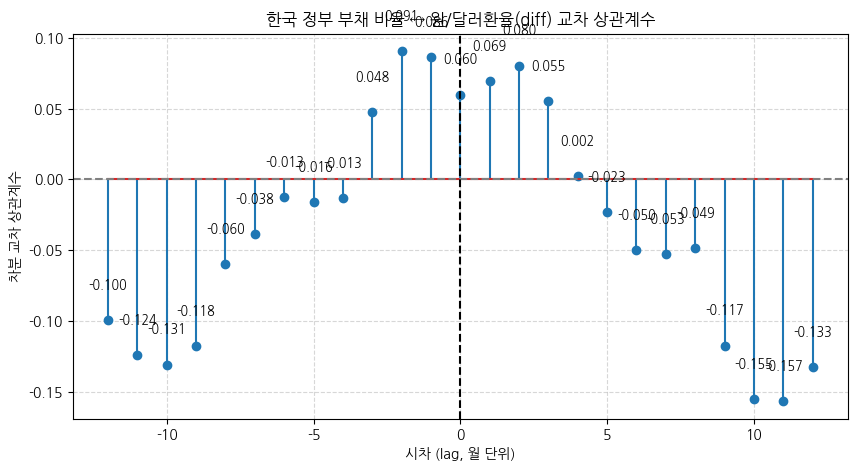

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 차분 계산
df = exchange_df.copy()
df['krw_diff'] = df['원/달러환율'].diff()
df['kordebt_diff'] = df['한국 정부 부채 비율'].diff()
df = df.dropna(subset=['krw_diff','kordebt_diff'])

# lag별 교차상관계수 계산 (diff)
lags = range(-12, 13)
cc_diff = [
    df['krw_diff'].corr(df['kordebt_diff'].shift(-lag))
    for lag in lags
]

# 그래프 출력
plt.figure(figsize=(10, 5))
plt.stem(lags, cc_diff)
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--')
plt.xlabel('시차 (lag, 월 단위)')
plt.ylabel('차분 교차 상관계수')
plt.title('한국 정부 부채 비율 ↔ 원/달러환율(diff) 교차 상관계수')
plt.grid(True, linestyle='--', alpha=0.5)

# 수치 표시
for x, y in zip(lags, cc_diff):
    plt.text(x, y + 0.02, f"{y:.3f}", ha='center', va='bottom', fontsize=9)

plt.show()

### **해석!**
**1. 기준**
- 그래프 중앙 lag0은 동일한 시점의 한국 정부 부채 비율과 원/달러 환율의 상관관계를 의미

**2. 왼쪽 구간 (lag<0) : 환율 선행 (환율이 먼저 발생)**
- lag = -10에서 -0.131 제일 높은 상관관계를 보임
- 10개월 전 환율 상승 → 한국 정부 부채 비율 하락

**3. 오른쪽 구간 (lag>0) : 한국 정부 부채 비율 선행 (한국 정부 부채 비율이 먼저 발생)**
- lag = +11에서 -0.157 상관관계를 보임
- 11개월 전 한국 정부 부채 비율 하락 → 환율 상승

### **Granger 인과검정**
**1. 정의**
- 과거의 한 변수 값이 다른 변수의 미래 값을 예측하는 데 통계적으로 유의미한 정보를 제공하는지”를 검정하는 방법

**2. 귀무·대립가설**
- 귀무가설(H₀): 변수 X의 과거 정보가 Y의 미래 값을 예측하는 데 도움이 되지 않는다.
- 대립가설(H₁): 변수 X의 과거 정보가 Y 예측에 유의미하게 기여한다.

- 과적합 위험: 너무 많은 지연을 고려하면 의미 없는 노이즈가 포함될 수 있음

**3. Lags(시차) : ±12개월**
- 분기별, 월별, 계절별 패턴이 존재할 수 있으니 파악하기 위해 1년을 기준으로 설정

**4. 해석**
- “X를 알면 Y를 예측하는 데 도움이 된다/안 된다”로 이해해야 한다.

In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

# 1) Granger 인과검정 실행
data = exchange_df[['원/달러환율','한국 정부 부채 비율']].dropna()
max_lag = 11
results = grangercausalitytests(data, maxlag=max_lag, verbose=False)

# 2) 결과를 리스트에 수집
rows = []
for lag, res in results.items():
    f_stat, p_value, _, _ = res[0]['ssr_ftest']  # ssr based F test
    rows.append({
        'lag': lag,
        'F-statistic': round(f_stat, 4),
        'p-value': round(p_value, 4),
        '유의 여부 (p<0.05)': p_value < 0.05
    })

# 3) DataFrame으로 변환 후 출력
df_gc = pd.DataFrame(rows).set_index('lag')
display(df_gc)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


,F-statistic,p-value,유의 여부 (p<0.05)
lag,,,
1,0.0001,0.9926,False
2,1.5298,0.2185,False
3,1.1132,0.3442,False
4,1.1867,0.3171,False
5,1.5989,0.1609,False
6,1.5651,0.1579,False
7,1.2907,0.2554,False
8,1.1289,0.3444,False
9,1.0124,0.4307,False


### **해석!**
1. 한국 정부 부채 비율의 과거 1~11개월 값을 알아도 환율을 예측할 수 없다"고 결론

-> 한국 정부 부채 비율이 상승하면 이후 환율이 상승한다”는 가설을 예측 가능성(predictability)의 관점에서 지지할 수 없음

## **가설6 : 미국의 정부부채비율이 높을수록 달러가 약세를 보여 원/달러 환율이 낮아질 것이다.**
- 미국의 정부부채비율이 높을수록 미국의 재정 건정성에 대한 우려가 발생하고, 그 결과, 달러가 약세를 보일 것이다. 즉, 원/달러 환율이 하락할 것이다.

## **상관관계 유의성 검정 (피어슨 상관계수)**

1. 귀무가설(H₀)
- 두 변수(한국 국채(10년) 수익률, 원/달러환율) 사이에 선형 상관관계가 없다 (즉, 모상관계수 ρ=0)

2. 대립가설(H₁)
- 두 변수 사이에 선형 상관관계가 있다 (ρ ≠ 0)




In [ ]:
import pandas as pd
from scipy.stats import pearsonr

# 1) 두 시리즈를 하나의 DataFrame에 합치고
df_merged = pd.concat([
    exchange_df['미국 정부 부채 비율'],
    exchange_df['원/달러환율']
], axis=1).rename(columns={
    '미국 정부 부채 비율': 'usdebt',
    '원/달러환율':     'usdkrw'
})

# 2) 둘 다 non‑NA인 행만 남기기
df_clean = df_merged.dropna()

# 3) 샘플 수 확인
print("샘플 수:", len(df_clean))

# 4) 분산(variance) 확인 — 상수 시리즈인지 검사
print("usdebt 분산:", df_clean['usdebt'].var())
print("usdkrw   분산:",   df_clean['usdkrw'].var())

# 5) Pearson 상관계수 계산
if len(df_clean) >= 2 and df_clean['usdebt'].var() > 0 and df_clean['usdkrw'].var() > 0:
    corr_coef, p_value = pearsonr(df_clean['usdebt'], df_clean['usdkrw'])
    print(f"p-value = {p_value:.4f}")
else:
    print("샘플이 너무 적거나 분산이 0인 시리즈가 있어 상관계수를 계산할 수 없습니다.")


샘플 수: 265
usdebt 분산: 579.7444052141936
usdkrw   분산: 9786.788298176101
p-value = 0.4598


### **원/달러환율 ~ 미국 정부 부채 비율 산점도 및 상관관계**

기울기 (Slope): 0.1874
절편 (Intercept): 1112.9127
결정계수 (R²): 0.0021
상관계수 (R): 0.0456


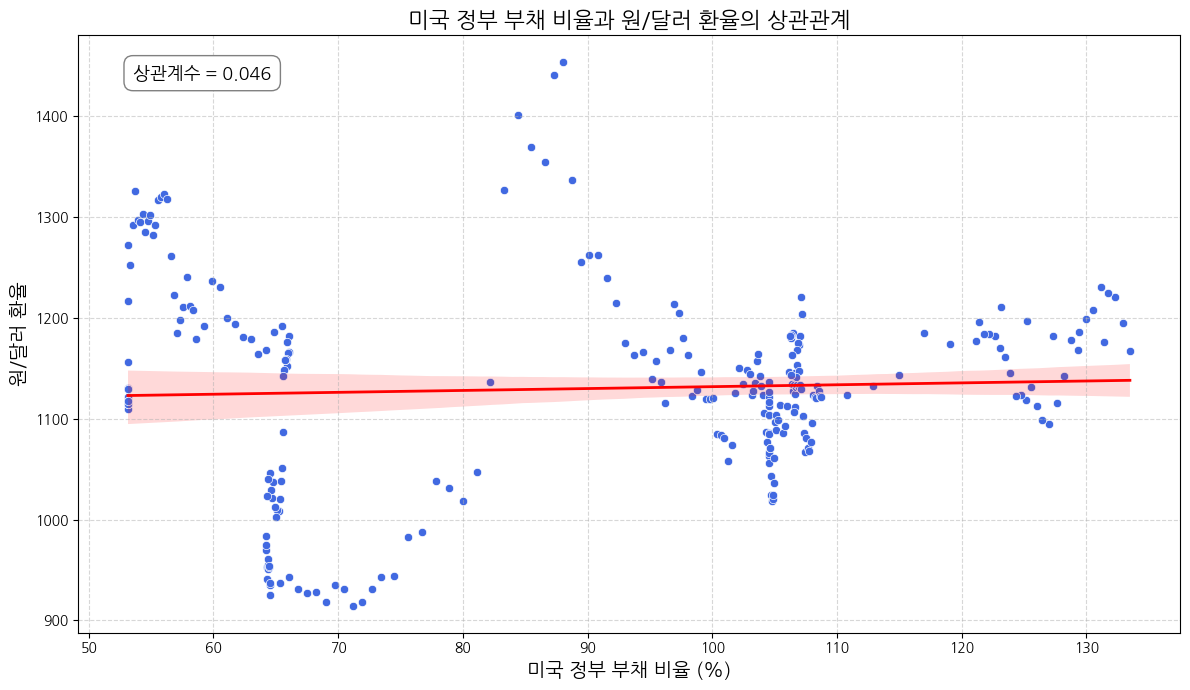

In [ ]:
from scipy.stats import linregress

# 필요한 컬럼만 선택하고 결측치 제거
df_clean = exchange_df[['미국 정부 부채 비율', '원/달러환율']].dropna()

# 회귀분석 수행
slope, intercept, r_value, p_value, std_err = linregress(df_clean['미국 정부 부채 비율'], df_clean['원/달러환율'])

# 콘솔에 결과 출력
print(f'기울기 (Slope): {slope:.4f}')
print(f'절편 (Intercept): {intercept:.4f}')
print(f'결정계수 (R²): {r_value**2:.4f}')
print(f'상관계수 (R): {r_value:.4f}')

# 산점도 및 회귀선
plt.figure(figsize=(12, 7))
sns.scatterplot(x='미국 정부 부채 비율', y='원/달러환율', data=df_clean, color='royalblue')
sns.regplot(x='미국 정부 부채 비율', y='원/달러환율', data=df_clean,
            scatter=False, color='red', line_kws={'linewidth': 2})

# 상관계수 박스
corr_text = f'상관계수 = {r_value:.3f}'
plt.text(0.05, 0.95, corr_text,
         fontsize=13, transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='gray'))

# 그래프 설정
plt.title('미국 정부 부채 비율과 원/달러 환율의 상관관계', fontsize=16)
plt.xlabel('미국 정부 부채 비율 (%)', fontsize=14)
plt.ylabel('원/달러 환율', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### **해석!**
**1. p-value = 0.4598**
- 0.4598 > 0.05 : 귀무가설 기각하지 않음
- 두 변수간의 선형관계가 존재하지 않다고 판단

**2. 결정계수(R²): 0.0021**
- 미국 정부 부채 비율은 환율 변동의 0.21%만 설명
- 정부 부채 비율이 환율의 움직임을 설명할 수 있는 능력은 매우 낮다.

**3. 상관계수 : 0.0456**
- 양수지만 매우 작은 값으로, 미국한국 정부 부채 비율 원/달러 환율 간의 선형적 상관관계는 거의 없음 (낮은 상관관계)

## **정상성 검정 ADF**

**1. 해석**
- p < 0.05: 정상성 있음 → 그대로 사용 가능
- p ≥ 0.05: 비정상 → 차분 후 사용해야 함

**2. 변수 → 둘 다 diff 적용해야함**
- 주가 지수
- 원/달러 환율

In [ ]:
from statsmodels.tsa.stattools import adfuller

adf_kospi = adfuller(exchange_df['미국 정부 부채 비율'].dropna())
adf_usdkrw = adfuller(exchange_df['원/달러환율'].dropna())
print(f'ADF 미국 정부 부채 비율 p-value: {adf_kospi[1]:.4f}')
print(f'ADF 환율 p-value: {adf_usdkrw[1]:.4f}')

ADF 미국 정부 부채 비율 p-value: 0.6051
ADF 환율 p-value: 0.4209


### **Cross-Correlation (교차 상관)**

#### **원본 데이터 (비정상성)**

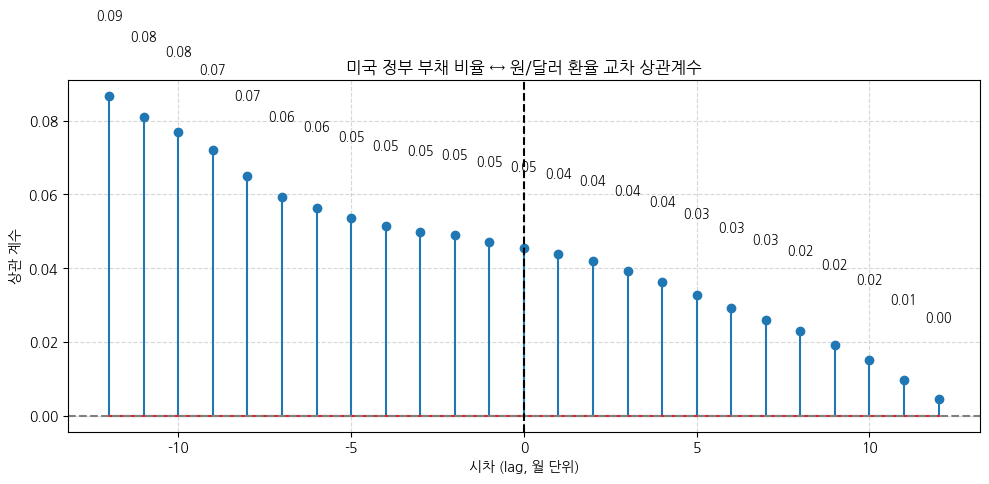

In [ ]:
import matplotlib.pyplot as plt

# 시차 범위
lags = range(-12, 13)

# 교차상관계수 계산
cc = [exchange_df['원/달러환율'].corr(exchange_df['미국 정부 부채 비율'].shift(-lag))
      for lag in lags]

# 시각화
plt.figure(figsize=(10, 5))
markerline, stemlines, baseline = plt.stem(lags, cc)

# 수치 라벨 추가
for lag, coef in zip(lags, cc):
    plt.text(lag, coef + 0.02 * (1 if coef >= 0 else -1), f'{coef:.2f}',
             ha='center', va='bottom' if coef >= 0 else 'top', fontsize=9)

# 보조선
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--')

# 레이아웃
plt.xlabel('시차 (lag, 월 단위)')
plt.ylabel('상관 계수')
plt.title('미국 정부 부채 비율 ↔ 원/달러 환율 교차 상관계수')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


#### **정상성을 적용한 데이터 (월간 변화량)**

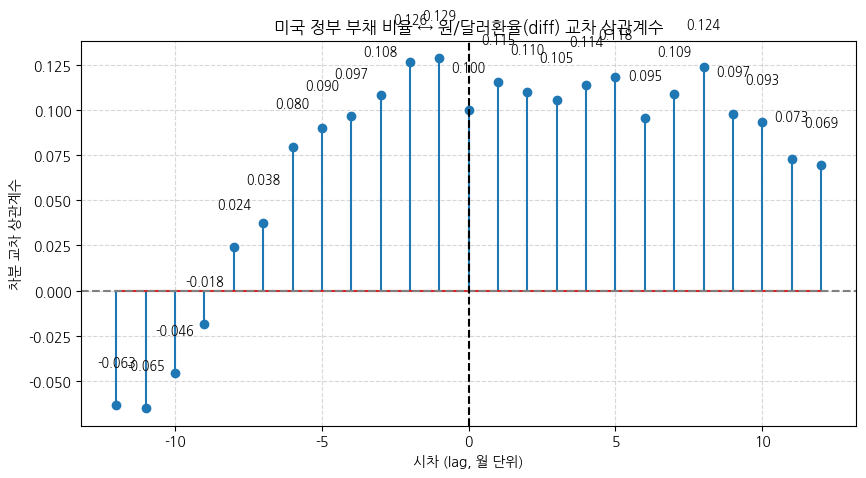

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 차분 계산
df = exchange_df.copy()
df['krw_diff'] = df['원/달러환율'].diff()
df['usdebt_diff'] = df['미국 정부 부채 비율'].diff()
df = df.dropna(subset=['krw_diff','usdebt_diff'])

# lag별 교차상관계수 계산 (diff)
lags = range(-12, 13)
cc_diff = [
    df['krw_diff'].corr(df['usdebt_diff'].shift(-lag))
    for lag in lags
]

# 그래프 출력
plt.figure(figsize=(10, 5))
plt.stem(lags, cc_diff)
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--')
plt.xlabel('시차 (lag, 월 단위)')
plt.ylabel('차분 교차 상관계수')
plt.title('미국 정부 부채 비율 ↔ 원/달러환율(diff) 교차 상관계수')
plt.grid(True, linestyle='--', alpha=0.5)

# 수치 표시
for x, y in zip(lags, cc_diff):
    plt.text(x, y + 0.02, f"{y:.3f}", ha='center', va='bottom', fontsize=9)

plt.show()

### **해석!**
**1. 기준**
- 그래프 중앙 lag0은 동일한 시점의 한국 정부 부채 비율과 원/달러 환율의 상관관계를 의미

**2. 왼쪽 구간 (lag<0) : 환율 선행 (환율이 먼저 발생)**
- lag = -1에서 0.129 제일 높은 상관관계를 보임
- 1개월 전 환율 상승 → 미국 정부 부채 비율 상승

**3. 오른쪽 구간 (lag>0) : 한국 정부 부채 비율 선행 (한국 정부 부채 비율이 먼저 발생)**
- lag = +5에서 0.118 상관관계를 보임
- 5개월 전 미국 정부 부채 비율 상승 → 환율 상승

### **Granger 인과검정**
**1. 정의**
- 과거의 한 변수 값이 다른 변수의 미래 값을 예측하는 데 통계적으로 유의미한 정보를 제공하는지”를 검정하는 방법

**2. 귀무·대립가설**
- 귀무가설(H₀): 변수 X의 과거 정보가 Y의 미래 값을 예측하는 데 도움이 되지 않는다.
- 대립가설(H₁): 변수 X의 과거 정보가 Y 예측에 유의미하게 기여한다.

- 과적합 위험: 너무 많은 지연을 고려하면 의미 없는 노이즈가 포함될 수 있음

**3. Lags(시차) : ±12개월**
- 분기별, 월별, 계절별 패턴이 존재할 수 있으니 파악하기 위해 1년을 기준으로 설정

**4. 해석**
- “X를 알면 Y를 예측하는 데 도움이 된다/안 된다”로 이해해야 한다.

In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

# 1) Granger 인과검정 실행
data = exchange_df[['원/달러환율','미국 정부 부채 비율']].dropna()
max_lag = 5
results = grangercausalitytests(data, maxlag=max_lag, verbose=False)

# 2) 결과를 리스트에 수집
rows = []
for lag, res in results.items():
    f_stat, p_value, _, _ = res[0]['ssr_ftest']  # ssr based F test
    rows.append({
        'lag': lag,
        'F-statistic': round(f_stat, 4),
        'p-value': round(p_value, 4),
        '유의 여부 (p<0.05)': p_value < 0.05
    })

# 3) DataFrame으로 변환 후 출력
df_gc = pd.DataFrame(rows).set_index('lag')
display(df_gc)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


,F-statistic,p-value,유의 여부 (p<0.05)
lag,,,
1,0.0324,0.8572,False
2,1.7698,0.1724,False
3,1.5436,0.2037,False
4,1.0026,0.4067,False
5,0.7575,0.5813,False


### **해석!**
1. **미국 정부 부채 비율의 과거 1~5개월 값을 알아도 환율을 예측할 수 없다**고 결론

-> 미국 정부 부채 비율이 상승하면 이후 환율이 상승한다는 가설을 예측 가능성(predictability)의 관점에서 **지지할 수 없음**

### **다중공선성**

상관계수 매트릭스:
              한국 정부 부채 비율  미국 정부 부채 비율
한국 정부 부채 비율     1.000000     0.962611
미국 정부 부채 비율     0.962611     1.000000


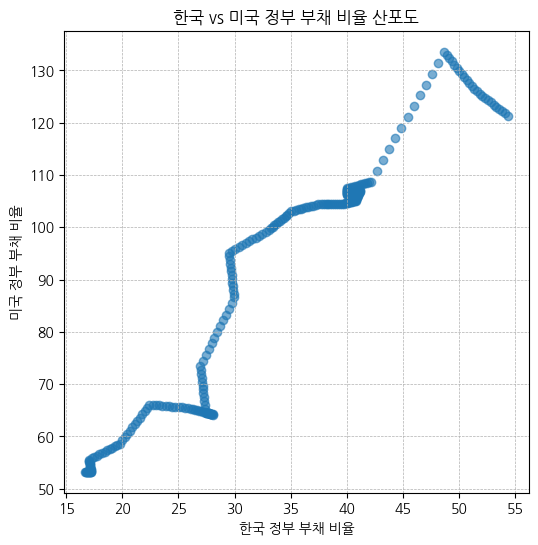


VIF 결과:
        feature        VIF
0  한국 정부 부채 비율  13.627727
1  미국 정부 부채 비율  13.627727
2    intercept  16.506090


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1) 필요한 컬럼만 추출＆결측치 제거
df_mc = exchange_df[['한국 정부 부채 비율', '미국 정부 부채 비율']].dropna()

# 2) 상관계수 확인
corr = df_mc.corr()
print("상관계수 매트릭스:\n", corr)

# (옵션) 산포도로 시각화
plt.figure(figsize=(6, 6))
plt.scatter(df_mc['한국 정부 부채 비율'], df_mc['미국 정부 부채 비율'], alpha=0.6)
plt.xlabel('한국 정부 부채 비율')
plt.ylabel('미국 정부 부채 비율')
plt.title('한국 vs 미국 정부 부채 비율 산포도')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

# 3) VIF 계산
#    VIF는 설명변수에 intercept(상수항)가 있어야 하므로 상수항 컬럼 추가
X = df_mc.copy()
X['intercept'] = 1.0

vif_data = pd.DataFrame({
    'feature': X.columns,
    'VIF': [variance_inflation_factor(X.values, i)
            for i in range(X.shape[1])]
})

print("\nVIF 결과:\n", vif_data)


한국 정부 부채 비율 (VIF ≈ 13.6)

미국 정부 부채 비율 (VIF ≈ 13.6)

일반적으로 VIF ≥ 10 은 “심각한 다중공선성”을 의미합니다.

두 변수 모두 10을 훌쩍 넘는 값이므로, 이 둘을 동시에 회귀모델에 투입하면 계수 추정이 매우 불안정해지고 해석이 왜곡될 가능성이 큽니다.

## **정리**



| 가설 번호 | 가설 내용                                                                                       | 예측 가능성(predictability) 결과 | 주요 해석 요약                                                 |
|:--------:|:----------------------------------------------------------------------------------------------|:-------------------------------:|:--------------------------------------------------------------|
| 1        | 한국 주가지수가 상승하면 원화 강세가 기대되어 원/달러 환율이 낮아질 것이다.                           | 지지할 수 없음                   | 과거 1–2개월 주가지수로는 환율 예측 불가                           |
| 2        | 미국 주가지수가 상승하면 달러 강세가 기대되어 원/달러 환율이 높아질 것이다.                         | 지지                              | 과거 1–9개월 주가지수로 환율 예측 가능, lag 1–2 구간에서 F‑statistic 높음 |
| 3        | 한국 10년물 국채 수익률이 높을수록 원화 강세로 환율이 낮아질 것이다.                                   | 지지할 수 없음                   | 과거 1–2개월 국채 수익률로는 환율 예측 불가                         |
| 4        | 미국 10년물 국채 수익률이 높을수록 달러 강세로 환율이 높아질 것이다.                                  | 지지할 수 없음                   | 과거 1–6개월 국채 수익률로는 환율 예측 불가                         |
| 5        | 한국 정부부채비율이 높을수록 원화 약세로 환율이 높아질 것이다.                                        | 지지할 수 없음                   | 과거 1–11개월 부채비율로는 환율 예측 불가                          |
| 6        | 미국 정부부채비율이 높을수록 달러 약세로 환율이 낮아질 것이다.                                       | 지지할 수 없음                   | 과거 1–5개월 부채비율로는 환율 예측 불가                           |

# **[기준금리]**

## **가설7 : 한국 기준금리가 상승하면 원화 강세 → 원/달러 환율 하락할 것이다.**

In [ ]:
exchange_df = df.copy()

In [ ]:
from scipy.stats import pearsonr

corr_coef, p_value = pearsonr(exchange_df['한국 기준 금리'], exchange_df['원/달러환율'])
print(f'p-value: {p_value:.4f}')

p-value: 0.0651


기울기 (Slope): -9.0613
절편 (Intercept): 1178.3269
결정계수 (R²): 0.0114
상관계수 (R): -0.1067


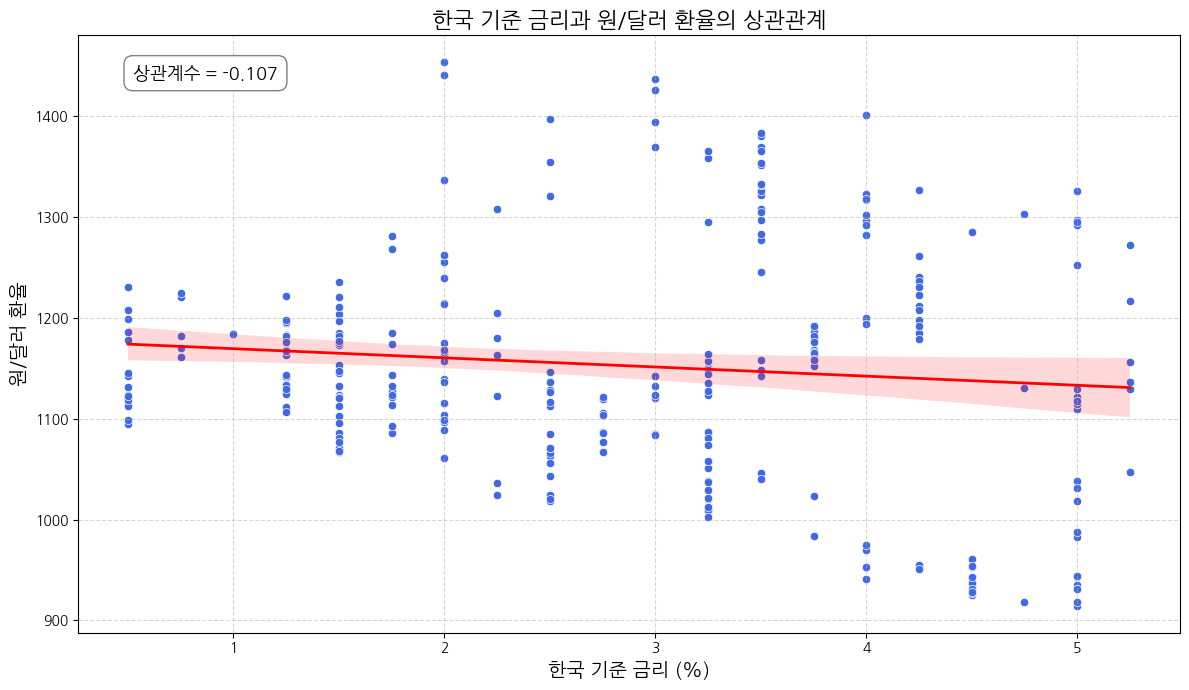

In [ ]:
from scipy.stats import linregress

# 필요한 컬럼만 선택하고 결측치 제거
df_clean = exchange_df[['한국 기준 금리', '원/달러환율']].dropna()

# 회귀분석 수행
slope, intercept, r_value, p_value, std_err = linregress(df_clean['한국 기준 금리'], df_clean['원/달러환율'])생

# 콘솔에 결과 출력
print(f'기울기 (Slope): {slope:.4f}')
print(f'절편 (Intercept): {intercept:.4f}')
print(f'결정계수 (R²): {r_value**2:.4f}')
print(f'상관계수 (R): {r_value:.4f}')

# 산점도 및 회귀선
plt.figure(figsize=(12, 7))
sns.scatterplot(x='한국 기준 금리', y='원/달러환율', data=df_clean, color='royalblue')
sns.regplot(x='한국 기준 금리', y='원/달러환율', data=df_clean,
            scatter=False, color='red', line_kws={'linewidth': 2})

# 상관계수 박스
corr_text = f'상관계수 = {r_value:.3f}'
plt.text(0.05, 0.95, corr_text,
         fontsize=13, transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='gray'))

# 그래프 설정
plt.title('한국 기준 금리과 원/달러 환율의 상관관계', fontsize=16)
plt.xlabel('한국 기준 금리 (%)', fontsize=14)
plt.ylabel('원/달러 환율', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## **가설8 : 미국 기준금리가 상승하면 달러 강세(원화 약세) → 원/달러 환율 상승할 것이다.**

In [ ]:
exchange_df = df.copy()

In [ ]:
from scipy.stats import pearsonr

corr_coef, p_value = pearsonr(exchange_df['미국 기준 금리'], exchange_df['원/달러환율'])
print(f'p-value: {p_value:.4f}')

p-value: 0.9147


기울기 (Slope): -0.3486
절편 (Intercept): 1153.1063
결정계수 (R²): 0.0000
상관계수 (R): -0.0062


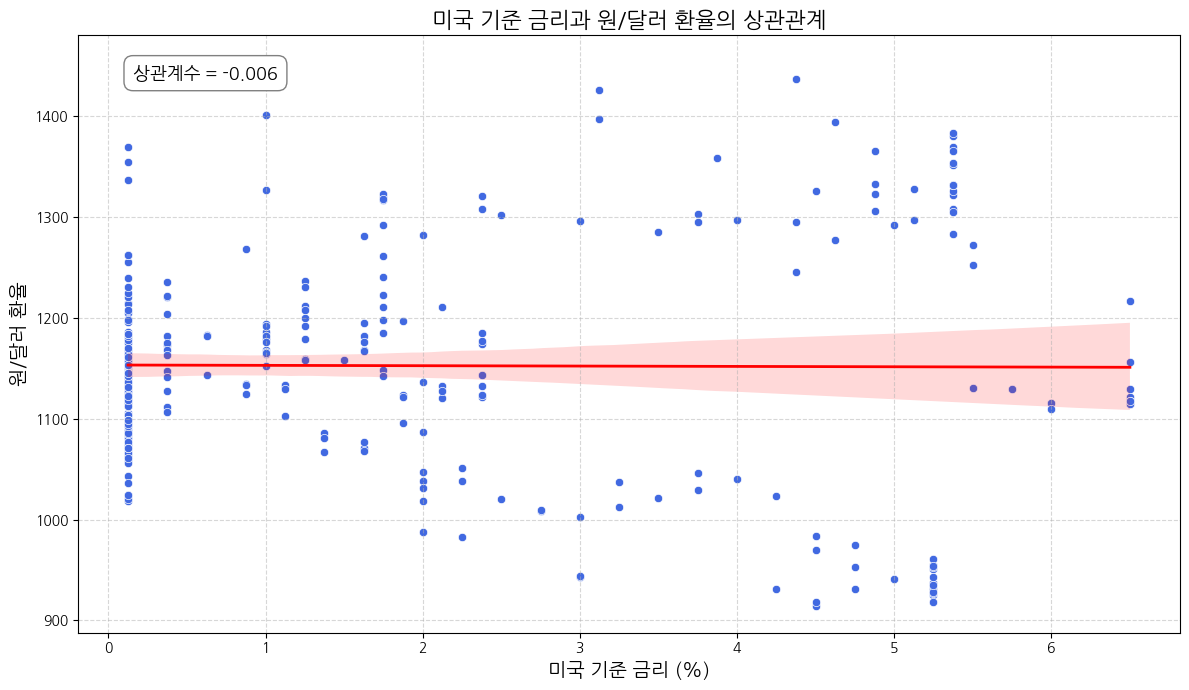

In [ ]:
from scipy.stats import linregress

# 필요한 컬럼만 선택하고 결측치 제거
df_clean = exchange_df[['미국 기준 금리', '원/달러환율']].dropna()

# 회귀분석 수행
slope, intercept, r_value, p_value, std_err = linregress(df_clean['미국 기준 금리'], df_clean['원/달러환율'])

# 콘솔에 결과 출력
print(f'기울기 (Slope): {slope:.4f}')
print(f'절편 (Intercept): {intercept:.4f}')
print(f'결정계수 (R²): {r_value**2:.4f}')
print(f'상관계수 (R): {r_value:.4f}')

# 산점도 및 회귀선
plt.figure(figsize=(12, 7))
sns.scatterplot(x='미국 기준 금리', y='원/달러환율', data=df_clean, color='royalblue')
sns.regplot(x='미국 기준 금리', y='원/달러환율', data=df_clean,
            scatter=False, color='red', line_kws={'linewidth': 2})

# 상관계수 박스
corr_text = f'상관계수 = {r_value:.3f}'
plt.text(0.05, 0.95, corr_text,
         fontsize=13, transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='gray'))

# 그래프 설정
plt.title('미국 기준 금리과 원/달러 환율의 상관관계', fontsize=16)
plt.xlabel('미국 기준 금리 (%)', fontsize=14)
plt.ylabel('원/달러 환율', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
exchange_df = df.copy()

In [ ]:
exchange_df['한미금리차'] = exchange_df['미국 기준 금리'] - exchange_df['한국 기준 금리']

In [ ]:
from scipy.stats import pearsonr

corr_coef, p_value = pearsonr(exchange_df['한미금리차'], exchange_df['원/달러환율'])
print(f'p-value: {p_value:.4f}')

p-value: 0.1411


기울기 (Slope): 6.3359
절편 (Intercept): 1158.3240
결정계수 (R²): 0.0073
상관계수 (R): 0.0852


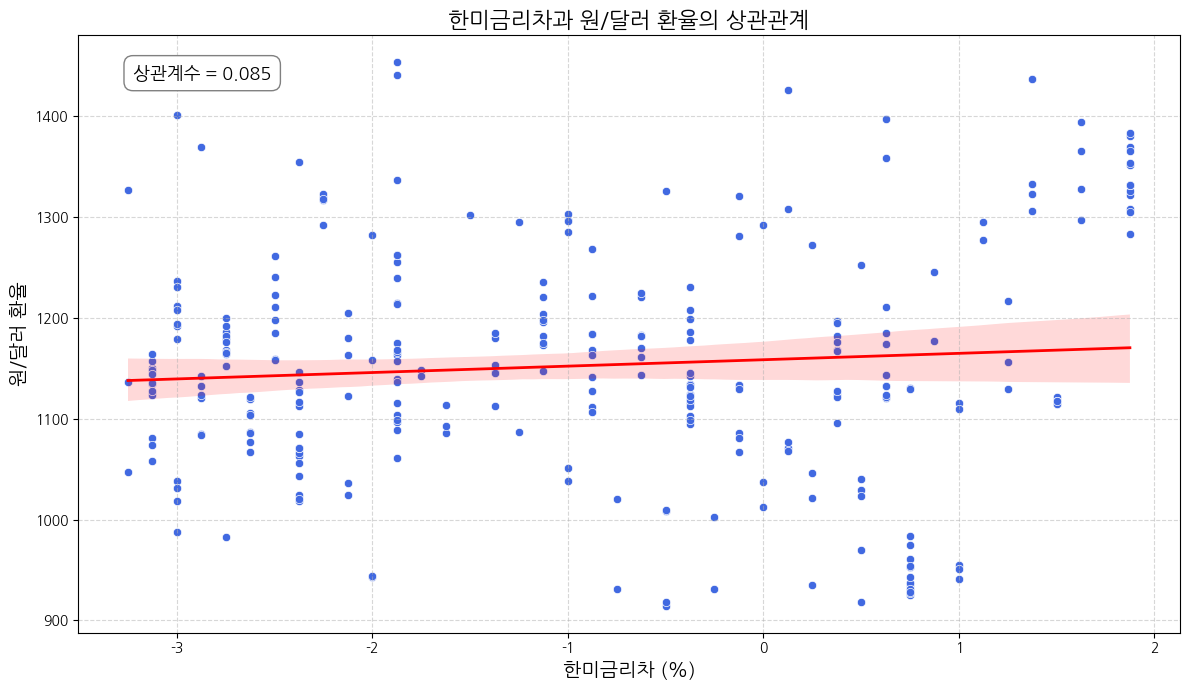

In [ ]:
from scipy.stats import linregress

# 필요한 컬럼만 선택하고 결측치 제거
df_clean = exchange_df[['한미금리차', '원/달러환율']].dropna()

# 회귀분석 수행
slope, intercept, r_value, p_value, std_err = linregress(df_clean['한미금리차'], df_clean['원/달러환율'])

# 콘솔에 결과 출력
print(f'기울기 (Slope): {slope:.4f}')
print(f'절편 (Intercept): {intercept:.4f}')
print(f'결정계수 (R²): {r_value**2:.4f}')
print(f'상관계수 (R): {r_value:.4f}')

# 산점도 및 회귀선
plt.figure(figsize=(12, 7))
sns.scatterplot(x='한미금리차', y='원/달러환율', data=df_clean, color='royalblue')
sns.regplot(x='한미금리차', y='원/달러환율', data=df_clean,
            scatter=False, color='red', line_kws={'linewidth': 2})

# 상관계수 박스
corr_text = f'상관계수 = {r_value:.3f}'
plt.text(0.05, 0.95, corr_text,
         fontsize=13, transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='gray'))

# 그래프 설정
plt.title('한미금리차과 원/달러 환율의 상관관계', fontsize=16)
plt.xlabel('한미금리차 (%)', fontsize=14)
plt.ylabel('원/달러 환율', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### **다중공선성**

상관계수 매트릭스:
           한국 기준 금리  미국 기준 금리
한국 기준 금리  1.000000  0.655966
미국 기준 금리  0.655966  1.000000


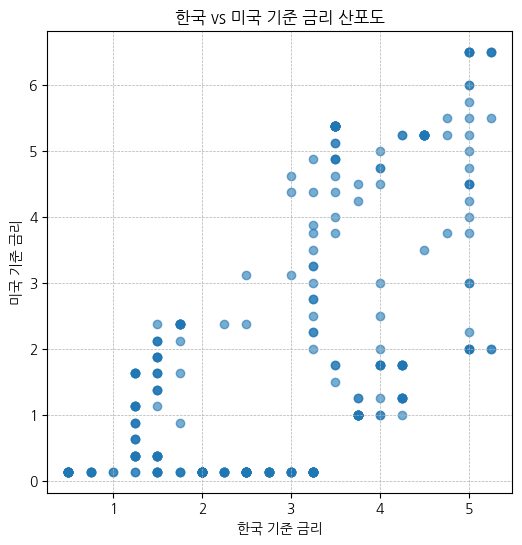


VIF 결과:
      feature       VIF
0   한국 기준 금리  1.755284
1   미국 기준 금리  1.755284
2  intercept  5.942737


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1) 필요한 컬럼만 추출＆결측치 제거
df_mc = exchange_df[['한국 기준 금리', '미국 기준 금리']].dropna()

# 2) 상관계수 확인
corr = df_mc.corr()
print("상관계수 매트릭스:\n", corr)

# (옵션) 산포도로 시각화
plt.figure(figsize=(6, 6))
plt.scatter(df_mc['한국 기준 금리'], df_mc['미국 기준 금리'], alpha=0.6)
plt.xlabel('한국 기준 금리')
plt.ylabel('미국 기준 금리')
plt.title('한국 vs 미국 기준 금리 산포도')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

# 3) VIF 계산
#    VIF는 설명변수에 intercept(상수항)가 있어야 하므로 상수항 컬럼 추가
X = df_mc.copy()
X['intercept'] = 1.0

vif_data = pd.DataFrame({
    'feature': X.columns,
    'VIF': [variance_inflation_factor(X.values, i)
            for i in range(X.shape[1])]
})

print("\nVIF 결과:\n", vif_data)
